In [1]:
import requests
import pandas as pd
from tqdm import tqdm
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url_inventory_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
url_stations_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
url_countries_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"
url_states_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt"
url_state_raw = "https://raw.githubusercontent.com/georgique/world-geojson/develop/states/usa/new_hampshire.json"

In [3]:
def parse_stations_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEVATION": float(line[31:37].strip()),
                "STATE": line[38:40].strip(),
                "NAME": line[38:68].strip(),
            })
    return pd.DataFrame(data)

def parse_inventory_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEMENT": line[31:35].strip(),
                "FIRSTYEAR": int(line[36:40].strip()),
                "LASTYEAR": int(line[41:45].strip())
            })
    return pd.DataFrame(data)

def parse_countries_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:64].strip()
            })
    return pd.DataFrame(data)

def parse_states_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:50].strip()
            })
    return pd.DataFrame(data)

def parse_data_dly(line):
    data = []
    for i in range(21, 269, 8):
        value = int(line[i:i+5])
        mflag = line[i+5]
        qflag = line[i+6]
        sflag = line[i+7]
        data.extend([value, mflag, qflag, sflag])
    return {
        "ID": line[0:11].strip(),
        "YEAR": int(line[11:15]),
        "Month": int(line[15:17]),
        "ELEMENT": line[17:21].strip(),
        "DATA": data
    }

def read_data_from_url(url):
    data = []
    response = requests.get(url)
    if response.status_code == 200:
        for line in response.text.splitlines():
            data.append(parse_data_dly(line))
    else:
        print(f"Failed to retrieve data for {url}. Status code: {response.status_code}")
    return data

def fetch_and_save_to_dataframe(station_ids):
    all_data = []
    for station_id in tqdm(station_ids, desc="Fetching Data", unit="station", ncols=100):
        url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly"
        data = read_data_from_url(url)
        all_data.extend(data)
    headers = ["ID", "YEAR", "Month", "ELEMENT"]
    for i in range(1, 32):
        headers.extend([f"VALUE{i}", f"MFLAG{i}", f"QFLAG{i}", f"SFLAG{i}"])
    df_data = []
    for entry in all_data:
        row = [entry["ID"], entry["YEAR"], entry["Month"], entry["ELEMENT"]]
        row.extend(entry["DATA"])
        df_data.append(row)
    return pd.DataFrame(df_data, columns=headers)


In [4]:
inventory = parse_inventory_txt(url_inventory_txt)
stations= parse_stations_txt(url_stations_txt)
countries = parse_countries_txt(url_countries_txt)
states = parse_states_txt(url_states_txt)

In [5]:
s_state_list=stations[stations['STATE']=='NH']['ID'].tolist()
s_live_list=inventory[(inventory['ID'].isin(s_state_list)) & (inventory['LASTYEAR']>=2024)]['ID'].unique().tolist()
result = inventory.loc[inventory['ID'].isin(s_live_list), ['ID', 'ELEMENT', 'FIRSTYEAR', 'LASTYEAR']]
result['YEAR_DIFF'] = result['LASTYEAR'] - result['FIRSTYEAR']
Req_station_list = pd.Series(result[(result['YEAR_DIFF'] >= 75) & (result['LASTYEAR'] > 2014)]['ID'].tolist()).unique()

In [6]:
data= fetch_and_save_to_dataframe(Req_station_list)

Fetching Data:   0%|                                                    | 0/20 [00:00<?, ?station/s]

Fetching Data: 100%|███████████████████████████████████████████| 20/20 [00:08<00:00,  2.31station/s]


: 

In [8]:
flag_columns = [col for col in data.columns if 'FLAG' in col]
data= data.drop(columns=flag_columns)
data.replace(-9999.0, np.nan, inplace=True)
weather_variables = ['TMAX', 'TMIN', 'SNOW', 'SNWD', 'PRCP']
data=data[data['ELEMENT'].isin(weather_variables)]

In [9]:
from collections import defaultdict
station_year_month = data.groupby(['ID', 'YEAR', 'Month']).size().reset_index(name='count')
missing_by_station = defaultdict(list)
stations_with_more_than_10_missing_years = []
for station in data['ID'].unique():
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    all_years = range(min_year, max_year)  
    all_months = range(1, 13)
    all_combinations = pd.MultiIndex.from_product([all_years, all_months], names=['YEAR', 'Month'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    station_data = station_year_month[station_year_month['ID'] == station]
    merged_data = pd.merge(all_combinations_df, station_data, on=['YEAR', 'Month'], how='left')
    missing_data = merged_data[merged_data['count'].isna()]
    missing_pairs = missing_data[['YEAR', 'Month']].itertuples(index=False, name=None)
    for pair in missing_pairs:
        missing_by_station[station].append((pair[0], pair[1]))

for station, pairs in missing_by_station.items():
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    years_missing = set([year for year, _ in pairs]) 
    months_missing = set([month for _, month in pairs])
    fully_missing_years = [year for year in years_missing if len(months_missing) == 12]
    if len(fully_missing_years) > 10:
        stations_with_more_than_10_missing_years.append(station)
stations_to_print = [station for station in missing_by_station.keys() if station not in stations_with_more_than_10_missing_years]


In [10]:
data=data[data['ID'].isin(stations_to_print)]

In [11]:
import pandas as pd
import numpy as np

# Extract Year-Month pairs
data['YEAR_MONTH'] = data['YEAR'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)

# List of unique stations
stations_list = data['ID'].unique()

# Initialize dictionary to store missing year-month pairs for each station
missing_year_month_pairs = {}

# Loop over each station to find missing year-month pairs
for station in stations_list:
    # Get the unique year-month pairs for the current station's data
    station_data = data[data['ID'] == station]
    available_year_month_pairs = set(station_data['YEAR_MONTH'])
    
    # Get the full range of year-month pairs for the station's year range
    min_year = station_data['YEAR'].min()
    max_year = station_data['YEAR'].max()
    
    full_year_month_pairs = set(
        [f"{year}-{str(month).zfill(2)}" for year in range(min_year, max_year) for month in range(1, 13)]
    )
    
    # Find missing year-month pairs
    missing_pairs = full_year_month_pairs - available_year_month_pairs
    missing_year_month_pairs[station] = sorted(list(missing_pairs))

# Print missing year-month pairs for each station
for station, missing_pairs in missing_year_month_pairs.items():
    print(f"Missing Year-Month pairs for station {station}: {missing_pairs}")


Missing Year-Month pairs for station USC00272174: ['1894-04', '1894-05', '1894-06', '1894-07', '1894-08', '1894-09', '1894-10', '1894-11', '1894-12', '1895-01', '1895-02', '1895-03', '1895-04', '1895-05', '1895-06', '1907-03', '1915-08', '1923-10', '1948-01', '1948-02', '1948-03', '1964-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06']
Missing Year-Month pairs for station USC00272999: ['1925-01', '1925-02', '1925-03', '1925-04', '1925-05', '1925-06', '1925-07', '1925-08', '1925-09', '1925-10', '1925-11', '1925-12', '1926-01', '1926-02', '1926-03', '1926-04', '1926-05', '1926-06', '1926-07', '1926-08', '1926-09', '1926-10', '1926-11', '1926-12', '1927-01', '1927-02', '1927-03', '1927-04', '1927-05', '1927-06', '1927-07', '1927-08', '1927-09', '1927-10', '1927-11', '1927-12', '1928-01', '1928-02', '1928-03', '1928-04', '1928-05', '1928-06', '1928-07', '1928-08', '1928-09', '1928-10', '1928-11', '1928-12', '1929-01', '1929-02', '1929-03', '1929-04', '1929-05', '1929-06', '1929-0

In [12]:
import pandas as pd

# Helper function to format output for each station
def format_station_output(station, missing_years, start_year, end_year):
    # Filter for whole missing years
    whole_missing_years = [year for year, months in missing_years.items() if len(months) == 12]

    # Sort missing years
    whole_missing_years.sort()
    
    # Print the start and end years of the station's data
    print(f"Station {station}:")
    print(f"Start year: {start_year}, End year: {end_year}")

    # Print whole missing years
    if whole_missing_years:
        print(f"Whole missing years: {', '.join(whole_missing_years)}")

    # Sort and print month-year missing pairs
    missing_pairs = {year: months for year, months in missing_years.items() if len(months) < 12}
    if missing_pairs:
        print(f"Missing month-year pairs:")
        for year in sorted(missing_pairs.keys()):
            print(f"Year {year}: Missing months {', '.join(sorted(missing_pairs[year]))}")
    
    print("\n" + "-"*50 + "\n")

# Extract Year-Month pairs and create a new column 'YEAR_MONTH'
data['YEAR_MONTH'] = data['YEAR'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)

# List of unique station IDs
stations_list = data['ID'].unique()

# Initialize dictionary to store missing year-month pairs for each station
missing_year_month_pairs = {}

# Loop through each station to find missing year-month pairs
for station in stations_list:
    # Filter data for the current station
    station_data = data[data['ID'] == station]
    
    # Get the start and end years for the current station
    start_year = station_data['YEAR'].min()
    end_year = station_data['YEAR'].max()
    
    # Get the unique year-month pairs for the station
    available_year_month_pairs = set(station_data['YEAR_MONTH'])
    
    # Generate the full range of year-month pairs for the station
    full_year_month_pairs = set(
        [f"{year}-{str(month).zfill(2)}" for year in range(start_year, end_year) for month in range(1, 13)]
    )
    
    # Find missing year-month pairs
    missing_pairs = full_year_month_pairs - available_year_month_pairs
    missing_year_month_pairs[station] = sorted(list(missing_pairs))
    
    # Organize missing year-month pairs by year
    missing_years = {}
    for pair in missing_pairs:
        year, month = pair.split('-')
        if year not in missing_years:
            missing_years[year] = []
        missing_years[year].append(month)
    
    # Format and print the output for this station
    format_station_output(station, missing_years, start_year, end_year)


Station USC00272174:
Start year: 1893, End year: 2024
Missing month-year pairs:
Year 1894: Missing months 04, 05, 06, 07, 08, 09, 10, 11, 12
Year 1895: Missing months 01, 02, 03, 04, 05, 06
Year 1907: Missing months 03
Year 1915: Missing months 08
Year 1923: Missing months 10
Year 1948: Missing months 01, 02, 03
Year 1964: Missing months 01
Year 2010: Missing months 02, 03, 04, 05, 06

--------------------------------------------------

Station USC00272999:
Start year: 1918, End year: 2025
Whole missing years: 1925, 1926, 1927, 1928, 1929
Missing month-year pairs:
Year 1973: Missing months 08

--------------------------------------------------

Station USC00273850:
Start year: 1884, End year: 2025
Missing month-year pairs:
Year 1884: Missing months 01, 02, 03, 04, 05, 06, 07, 08, 09, 10
Year 1892: Missing months 04
Year 1893: Missing months 01, 02, 03, 04, 05
Year 1965: Missing months 03
Year 1980: Missing months 09
Year 1989: Missing months 11

----------------------------------------

In [13]:
# Start years for each station
start_years = {
    "USC00272174": 1896,
    "USC00272999": 1930,
    "USC00273850": 1894,
    "USC00274399": 1894,
    "USC00275211": 1942,
    "USC00275868": 1930,
    "USC00276818": 1930,
    "USW00014745": 1940,
}

# Loop through each station and filter the data accordingly
for station in start_years:
    # Get the start year for the current station
    start_year = start_years[station]
    
    # Filter the DataFrame to remove rows where the 'YEAR' is less than the start year for the station
    data = data[(data['ID'] != station) | (data['YEAR'] >= start_year)]




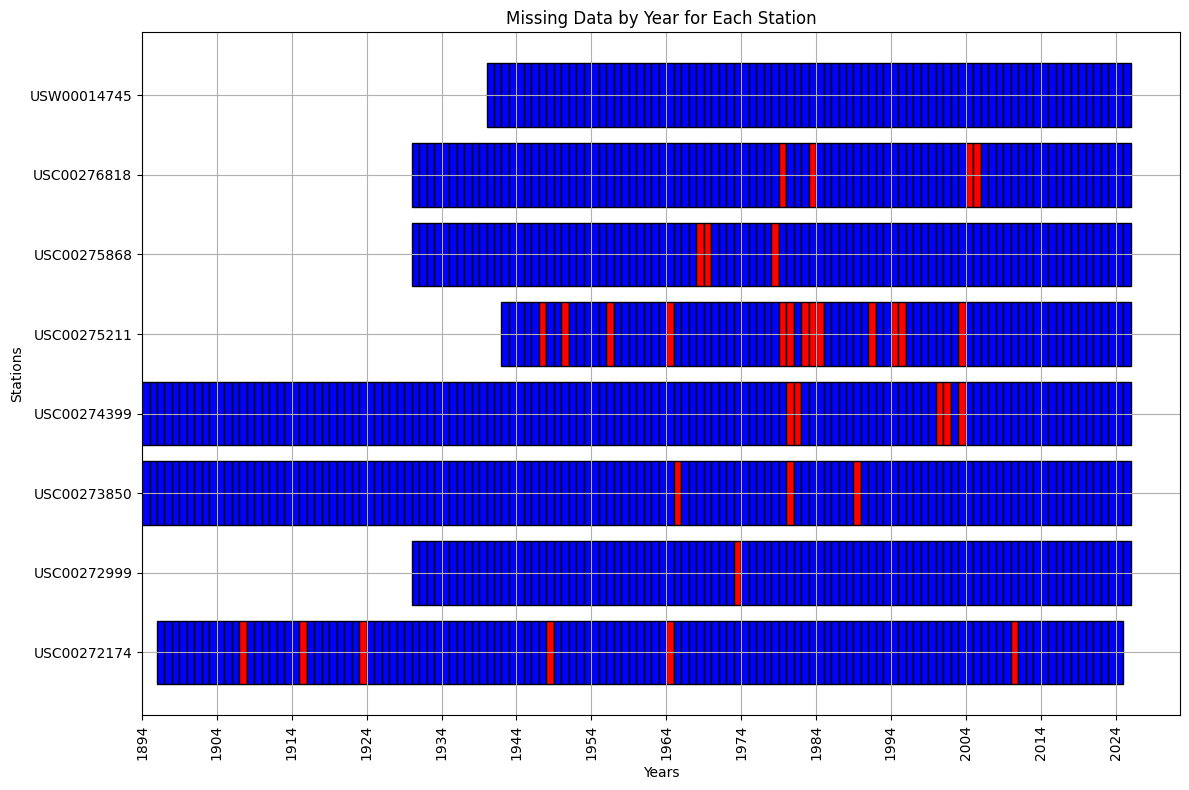

In [14]:
# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create a color map for missing data and available data
missing_color = 'red'
available_color = 'blue'

# Find the overall min and max year across all stations
min_overall_year = min([data[data['ID'] == station]['YEAR'].min() for station in stations_to_print])
max_overall_year = max([data[data['ID'] == station]['YEAR'].max() for station in stations_to_print])

# Loop over each station to create the plot
for idx, station in enumerate(stations_to_print):
    # Get the min and max years for the station
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()

    # Ensure min_year and max_year are different
    if min_year == max_year:
        continue

    # Generate a 2D grid for years (x-axis) and months (y-axis) if the years are valid
    if min_year < max_year:
        years = np.arange(min_year, max_year + 1)

        # Initialize a matrix to represent data availability (1 for missing data, 0 for available data)
        availability_matrix = np.zeros(len(years))

        # Mark missing year-month pairs
        for year, _ in missing_by_station.get(station, []):
            year_indices = np.where(years == year)
            if year_indices[0].size > 0:
                year_idx = year_indices[0][0]
                availability_matrix[year_idx] = 1  # Mark missing data as 1

        # Create bars for each year, marking missing data in red and available data in blue
        for i, year in enumerate(years):
            if availability_matrix[i] == 1:
                ax.barh(idx, 1, left=year, height=0.8, color=missing_color, edgecolor='black')
            else:
                ax.barh(idx, 1, left=year, height=0.8, color=available_color, edgecolor='black')

# Set labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Stations')
ax.set_title('Missing Data by Year for Each Station')

# Customize year labels on x-axis: show first, last, and every 10th year
x_ticks = [min_overall_year] + list(range(min_overall_year + 10, max_overall_year, 10)) 
ax.set_xticks(x_ticks)

# Customize station names on y-axis
ax.set_yticks(np.arange(len(stations_to_print)))
ax.set_yticklabels(stations_to_print)  # Use the stations_to_print list

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Add grid
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
state_stations = stations[stations['STATE']=='NH']
state_lat = state_stations['LATITUDE'].mean()
state_lon = state_stations['LONGITUDE'].mean()
state_map = folium.Map(location=[state_lat, state_lon], 
                       zoom_start=7.5,
                       min_zoom=6,
                       max_zoom=10)

stations_to_plot = stations[stations['ID'].isin(stations_to_print)]
for _, row in stations_to_plot.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['NAME'],
        tooltip=row['NAME']
    ).add_to(state_map)
try:
    geojson_data = requests.get(url_state_raw).json() 
    folium.GeoJson(geojson_data, name="State Boundary").add_to(state_map)
except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    
state_map

In [16]:
import pandas as pd
import os

# Function to extract and save individual variable dataframes
def extract_and_save_variable_dataframes(df, variables, output_dir='Data/Variable_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    dataframes = {}
    for var in variables:
        var_df = df[df['ELEMENT'] == var].copy()
        dataframes[var] = var_df
        var_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)
        
    return dataframes

# Function to transform data to daily records
def transform_to_daily_data(df, element):
    # Initialize a list to store transformed data
    transformed_data = []
    
    # Loop over each row (station data) in the DataFrame
    for _, row in df.iterrows():
        # Get the station's ID, season, and month values
        station_id = row['ID']
        year = row['YEAR']
        month = row['Month']
        
        # Loop through each day's value in the row (VALUE1 to VALUE31)
        for day in range(1, 32):
            # Construct the date for each day
            date_str = f"{year}-{month:02d}-{day:02d}"
            
            # Get the value for that day (e.g., VALUE1 corresponds to day 1, VALUE2 to day 2, etc.)
            value_column = f'VALUE{day}'
            element_value = row.get(value_column, None)
            
            # If the value exists (not NaN), create a new record for that day
            if pd.notna(element_value):
                transformed_data.append({
                    'DATE': date_str,
                    'ID': station_id,
                    element: element_value
                })
    
    # Convert the list of transformed data into a DataFrame
    transformed_df = pd.DataFrame(transformed_data)
    return transformed_df

# Function to transform all variable dataframes into daily records and save the transformed data
def transform_all_variables_to_daily_data(variable_dfs, output_dir='Data/Transform_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through each variable dataframe and transform it to daily data
    for var, df in variable_dfs.items():
        transformed_df = transform_to_daily_data(df, var)
        
        # Save the transformed data for each variable to a CSV file
        transformed_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)

# Example usage:

# Assuming 'data' is your original DataFrame and 'weather_variables' contains the list of variable names
# Extract and save data for each variable
variable_dfs = extract_and_save_variable_dataframes(data, weather_variables)

# Transform the saved data to daily records and save the output
transform_all_variables_to_daily_data(variable_dfs)


In [17]:
import pandas as pd
import glob

def combine_csv_files(directory_path: str) -> pd.DataFrame:
    # List all CSV files from the specified directory
    csv_files = glob.glob(f'{directory_path}/*_data.csv')

    # Check if there are any files found
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the directory: {directory_path}")

    # Start by reading the first CSV file
    combined_df = pd.read_csv(csv_files[0])

    # Loop through the rest of the CSV files and merge them one by one
    for file in csv_files[1:]:
        df = pd.read_csv(file)
        
        # Rename columns to avoid conflicts (split by the first '_' to avoid suffixes like 'Season_x', 'Season_y')
        df = df.rename(columns=lambda x: x.split('_')[0] if '_' in x else x)

        # Merge on 'ID' and 'DATE' columns, with suffixes to prevent naming conflicts
        combined_df = pd.merge(combined_df, df, on=['ID', 'DATE'], how='outer', suffixes=('_left', '_right'))

    # Return the combined DataFrame
    return combined_df


combined_df = combine_csv_files('Data/Transform_Data')

# Display the first few rows of the combined DataFrame
print(combined_df.head())


         DATE           ID  SNWD  SNOW   TMIN   TMAX  PRCP
0  1896-01-01  USC00272174   NaN   0.0 -111.0   11.0   NaN
1  1896-01-02  USC00272174   NaN   0.0 -128.0   28.0   NaN
2  1896-01-03  USC00272174   NaN   0.0  -72.0   67.0   NaN
3  1896-01-04  USC00272174   NaN   0.0 -178.0    6.0   NaN
4  1896-01-05  USC00272174   NaN   0.0 -200.0 -122.0   NaN


In [ ]:
import pandas as pd

# Function to add the 'Season' column
def add_season_column(df):
    # Convert 'DATE' column to datetime format if it's not already
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    
    # Define a function to assign seasons based on month
    def get_season(month):
        if month in [12, 1, 2]:  # Winter: Dec, Jan, Feb
            return 'Winter'
        elif month in [3, 4, 5]:  # Spring: Mar, Apr, May
            return 'Spring'
        elif month in [6, 7, 8]:  # Summer: Jun, Jul, Aug
            return 'Summer'
        else:  # Fall: Sep, Oct, Nov
            return 'Fall'
    
    # Apply the function to create the 'Season' column based on the month of the 'DATE'
    df['Season'] = df['DATE'].dt.month.apply(get_season)
    
    return df

# Example usage:
# Assuming 'combined_df' is your DataFrame

# Add the 'Season' column
combined_df = add_season_column(combined_df)

# Display the updated DataFrame
print(combined_df.head())


In [21]:
# Function to process columns, divide by 10, and update column names with units
def process_columns_with_units(df, columns_to_divide, units):
    # Ensure the relevant columns are numeric (force conversion and handle errors)
    for col in columns_to_divide:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce invalid values to NaN
    
    # Divide the relevant columns by 10 and add units
    for col in columns_to_divide:
        if col == 'SNOW':
            df.rename(columns={col: f"{col}"}, inplace=True)
        else:
            df[col] = df[col] / 10  # Divide by 10 as needed
        # Update column name to include unit
            df.rename(columns={col: f"{col}"}, inplace=True)
    
    return df

columns_to_divide = ['TMIN', 'TMAX', 'PRCP','SNOW','SNWD']
units = {
    'TMIN': '°C',   # Minimum temperature in tenths of °C
    'TMAX': '°C',   # Maximum temperature in tenths of °C
    'PRCP': 'mm',   # Precipitation in tenths of mm
    'SNOW': 'mm',   # Snowfall in mm
    'SNWD': 'cm',   # Snow depth in cm 
}

# Apply the function to your DataFrame
combined_df = process_columns_with_units(combined_df, columns_to_divide, units)

# Display the updated DataFrame
print(combined_df.head())


        DATE           ID  Season  TMIN  TMAX  PRCP  SNOW  SNWD
0 1896-01-01  USC00272174  Winter -1.11  0.11   NaN   0.0   NaN
1 1896-01-02  USC00272174  Winter -1.28  0.28   NaN   0.0   NaN
2 1896-01-03  USC00272174  Winter -0.72  0.67   NaN   0.0   NaN
3 1896-01-04  USC00272174  Winter -1.78  0.06   NaN   0.0   NaN
4 1896-01-05  USC00272174  Winter -2.00 -1.22   NaN   0.0   NaN


In [ ]:
df_combined = pd.merge(combined_df, stations, on='ID', how='left')

# Select only the required columns
df_combined = df_combined[['DATE','ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'Season', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD']]


             DATE           ID  LATITUDE  LONGITUDE  ELEVATION  \
0      1896-01-01  USC00272174   43.1419   -70.9500       23.2   
1      1896-01-02  USC00272174   43.1419   -70.9500       23.2   
2      1896-01-03  USC00272174   43.1419   -70.9500       23.2   
3      1896-01-04  USC00272174   43.1419   -70.9500       23.2   
4      1896-01-05  USC00272174   43.1419   -70.9500       23.2   
...           ...          ...       ...        ...        ...   
306199 2025-02-20  USW00014745   43.2050   -71.5025      103.0   
306200 2025-02-21  USW00014745   43.2050   -71.5025      103.0   
306201 2025-02-22  USW00014745   43.2050   -71.5025      103.0   
306202 2025-02-23  USW00014745   43.2050   -71.5025      103.0   
306203 2025-02-24  USW00014745   43.2050   -71.5025      103.0   

                   NAME  Season  TMIN  TMAX  PRCP  SNOW  SNWD  
0             NH DURHAM  Winter -1.11  0.11   NaN   0.0   NaN  
1             NH DURHAM  Winter -1.28  0.28   NaN   0.0   NaN  
2             N

In [37]:
df_combined.to_csv('Data/Final.csv', index=False)

In [38]:
df=pd.read_csv('Data/Final.csv')

In [39]:
import pandas as pd

# Assuming your data is in a dataframe called df
def find_missing_dates(df):
    # Convert 'DATE' column to datetime format if it's not already
    df['DATE'] = pd.to_datetime(df['DATE']).dt.date  # Use .dt.date to keep only the date part
    
    # Create an empty list to store the missing dates info
    missing_dates_info = []
    
    # Group the data by station ID
    for station_id, station_data in df.groupby('ID'):
        # Create a full date range from the minimum to the maximum date for the station
        date_range = pd.date_range(start=station_data['DATE'].min(), end=station_data['DATE'].max()).date
        
        # Find the existing dates for this station
        existing_dates = set(station_data['DATE'])
        
        # Find the missing dates by comparing the date range to the existing dates
        missing_dates = [date for date in date_range if date not in existing_dates]
        
        # Format the missing dates into ranges
        if missing_dates:
            ranges = []
            start_date = missing_dates[0]
            end_date = missing_dates[0]
            
            for i in range(1, len(missing_dates)):
                if missing_dates[i] == end_date + pd.Timedelta(days=1):  # If the next date is consecutive
                    end_date = missing_dates[i]
                else:
                    # If the gap is not consecutive, add the current range
                    ranges.append(f"{start_date} to {end_date}" if start_date != end_date else str(start_date))
                    start_date = missing_dates[i]
                    end_date = missing_dates[i]
            
            # Add the last range
            ranges.append(f"{start_date} to {end_date}" if start_date != end_date else str(start_date))
            
            # Store the missing dates along with the station ID
            missing_dates_info.append({
                'Station': station_id,
                'Missing Dates': ', '.join(ranges)
            })
    
    # Convert the result to a DataFrame for better readability
    missing_dates_df = pd.DataFrame(missing_dates_info)
    
    return missing_dates_df

# Example Usage
missing_dates = find_missing_dates(df)

# Print the missing dates for each station in a more readable format
for index, row in missing_dates.iterrows():
    print(f"Station: {row['Station']}")
    missing_dates_list = row['Missing Dates'].split(", ")
    for missing in missing_dates_list:
        print(f"  {missing}")
    print("-" * 60)  # Separator for better readability


Station: USC00272174
  1907-03-01 to 1907-03-31
  1909-04-08
  1915-08-01 to 1915-08-31
  1923-10-01 to 1923-10-31
  1930-05-16
  1936-08-10
  1938-02-27
  1938-03-01
  1938-05-19
  1942-05-27
  1943-02-18
  1944-02-17
  1945-06-08
  1946-07-27
  1947-02-05
  1947-11-20
  1948-01-01 to 1948-03-31
  1964-01-01 to 1964-01-31
  1983-07-31
  1997-03-14
  1999-01-15
  2001-03-02
  2003-10-17
  2003-11-15
  2003-11-29 to 2003-11-30
  2004-03-01 to 2004-03-14
  2004-11-11
  2005-11-06 to 2005-11-07
  2005-11-20 to 2005-11-21
  2005-12-27
  2006-01-22
  2006-01-26
  2006-04-16
  2006-11-07 to 2006-11-08
  2007-12-20
  2009-01-17
  2010-02-01 to 2010-06-30
  2011-01-12
  2011-01-14 to 2011-01-19
  2011-02-01
  2011-07-06
  2012-02-02
  2012-02-09
  2012-02-15
  2012-02-23
  2012-03-01
  2012-03-05
  2012-03-14
  2012-04-05
  2012-04-11
  2012-04-16
  2012-04-25
  2012-05-01
  2012-05-08
  2012-05-18
  2012-05-20
  2012-05-28
  2012-06-04
  2012-06-30
  2012-07-12
  2012-09-03
  2012-10-29
  201

In [ ]:
df.describe()

LATITUDE      LONGITUDE      ELEVATION           TMIN  \
count  306204.000000  306204.000000  306204.000000  282056.000000   
mean       43.563302     -71.681406     226.454738       0.069003   
std         0.676784       0.528905     192.461117       1.084332   
min        42.938900     -72.324700      23.200000      -4.220000   
25%        42.989200     -72.285600     103.000000      -0.610000   
50%        43.205000     -71.502500     155.800000       0.110000   
75%        43.705300     -71.252500     234.700000       0.940000   
max        45.090000     -70.950000     617.200000      27.670000   

                TMAX           PRCP           SNOW           SNWD  
count  282131.000000  290360.000000  251880.000000  227217.000000  
mean        1.319799       0.310660       6.739654       0.977610  
std         1.152427       0.780283      33.512188       2.207014  
min        -3.110000       0.000000       0.000000       0.000000  
25%         0.390000       0.000000       0.000000       0.000000  
50%         1.390000       0.000000       0.000000       0.000000  
75%         2.330000       0.230000       0.000000       0.760000  
max         4.060000      22.810000    7884.000000     203.960000

: 

In [33]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd

def interpolate_missing_dates(df, column_name='TMIN'):
    # Ensure 'DATE' is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE']).dt.date
    
    # Sort data by ID and DATE to ensure proper interpolation order
    df.sort_values(by=['ID', 'DATE'], inplace=True)
    
    # Create a list to store interpolated results
    interpolated_data = []

    # Group by station (ID)
    for station_id, station_data in df.groupby('ID'):
        # Create a full date range for this station (from min to max date)
        full_date_range = pd.date_range(start=station_data['DATE'].min(), end=station_data['DATE'].max()).date
        
        # Store the current available dates as a set for quick look-up
        existing_dates = set(station_data['DATE'])
        
        # Loop over each date in the full date range
        for date in full_date_range:
            # If the date is missing (not in existing_dates)
            if date not in existing_dates:
                # Handle the case for the previous month (January -> December of the previous year)
                if date.month == 1:
                    prev_month = pd.Timestamp(date).replace(year=date.year-1, month=12, day=31)  # Use December 31st of the previous year
                else:
                    prev_month = pd.Timestamp(date) - pd.DateOffset(months=1)  # Use the last day of the previous month

                # Find the closest date in the previous month that exists in the dataset
                prev_month_data = station_data[station_data['DATE'] == prev_month.date()]
                
                # If we found the previous month's data, use it for interpolation
                if not prev_month_data.empty:
                    interpolated_data.append({
                        'ID': station_id,
                        'DATE': date,
                        column_name: prev_month_data.iloc[0][column_name]
                    })
                
                # Optionally, you can also consider interpolation based on the previous year's data, but that part is not included here.

            # If the date is already present, just append it without interpolation
            else:
                interpolated_data.append({
                    'ID': station_id,
                    'DATE': date,
                    column_name: station_data[station_data['DATE'] == date].iloc[0][column_name]
                })
    
    # Create a DataFrame for the interpolated data
    interpolated_df = pd.DataFrame(interpolated_data)
    
    return interpolated_df

# Example usage:
# Assuming you want to interpolate the TMIN (minimum temperature)
interpolated_df = interpolate_missing_dates(df, column_name='TMIN')

# Displaying first few rows of interpolated data
print(interpolated_df.head())


KeyboardInterrupt: 

In [84]:
import pandas as pd

# Function to calculate correlation for each season
def correlation_by_season(df):
    # First, group the data by 'Season'
    seasons = df['Season'].unique()
    
    # Create an empty dictionary to store correlation matrices for each season
    correlation_matrices = {}
    
    # Iterate through each season and calculate correlation
    for season in seasons:
        season_df = df[df['Season'] == season]
        
        # Only keep the numerical columns for correlation calculation
        numerical_columns = season_df.select_dtypes(include='number')
        
        # Calculate the correlation matrix for the season's data
        correlation_matrix = numerical_columns.corr()
        
        # Store the correlation matrix in the dictionary
        correlation_matrices[season] = correlation_matrix
    
    return correlation_matrices

# Example usage:
# Assuming 'combined_df' is your DataFrame with the 'Season' column added

# Calculate correlation for each season
correlation_matrices = correlation_by_season(combined_df)

# Display correlation matrices for each season
for season, corr_matrix in correlation_matrices.items():
    print(f"Correlation Matrix for {season}:")
    print(corr_matrix)
    print("\n")


Correlation Matrix for Winter:
          TMIN(°C)  TMAX(°C)  PRCP(mm)  SNOW(mm)  SNWD(cm)
TMIN(°C)  1.000000  0.748161  0.233258 -0.000670 -0.368425
TMAX(°C)  0.748161  1.000000  0.159069 -0.123971 -0.350819
PRCP(mm)  0.233258  0.159069  1.000000  0.522766  0.063608
SNOW(mm) -0.000670 -0.123971  0.522766  1.000000  0.252037
SNWD(cm) -0.368425 -0.350819  0.063608  0.252037  1.000000


Correlation Matrix for Spring:
          TMIN(°C)  TMAX(°C)  PRCP(mm)  SNOW(mm)  SNWD(cm)
TMIN(°C)  1.000000  0.759601  0.130315 -0.179432 -0.519485
TMAX(°C)  0.759601  1.000000 -0.093729 -0.279083 -0.520118
PRCP(mm)  0.130315 -0.093729  1.000000  0.363268  0.045904
SNOW(mm) -0.179432 -0.279083  0.363268  1.000000  0.321453
SNWD(cm) -0.519485 -0.520118  0.045904  0.321453  1.000000


Correlation Matrix for Summer:
          TMIN(°C)  TMAX(°C)  PRCP(mm)  SNOW(mm)  SNWD(cm)
TMIN(°C)  1.000000  0.504780  0.149239  0.006623 -0.000550
TMAX(°C)  0.504780  1.000000 -0.178757  0.002045 -0.002188
PRCP(mm)  0.149239

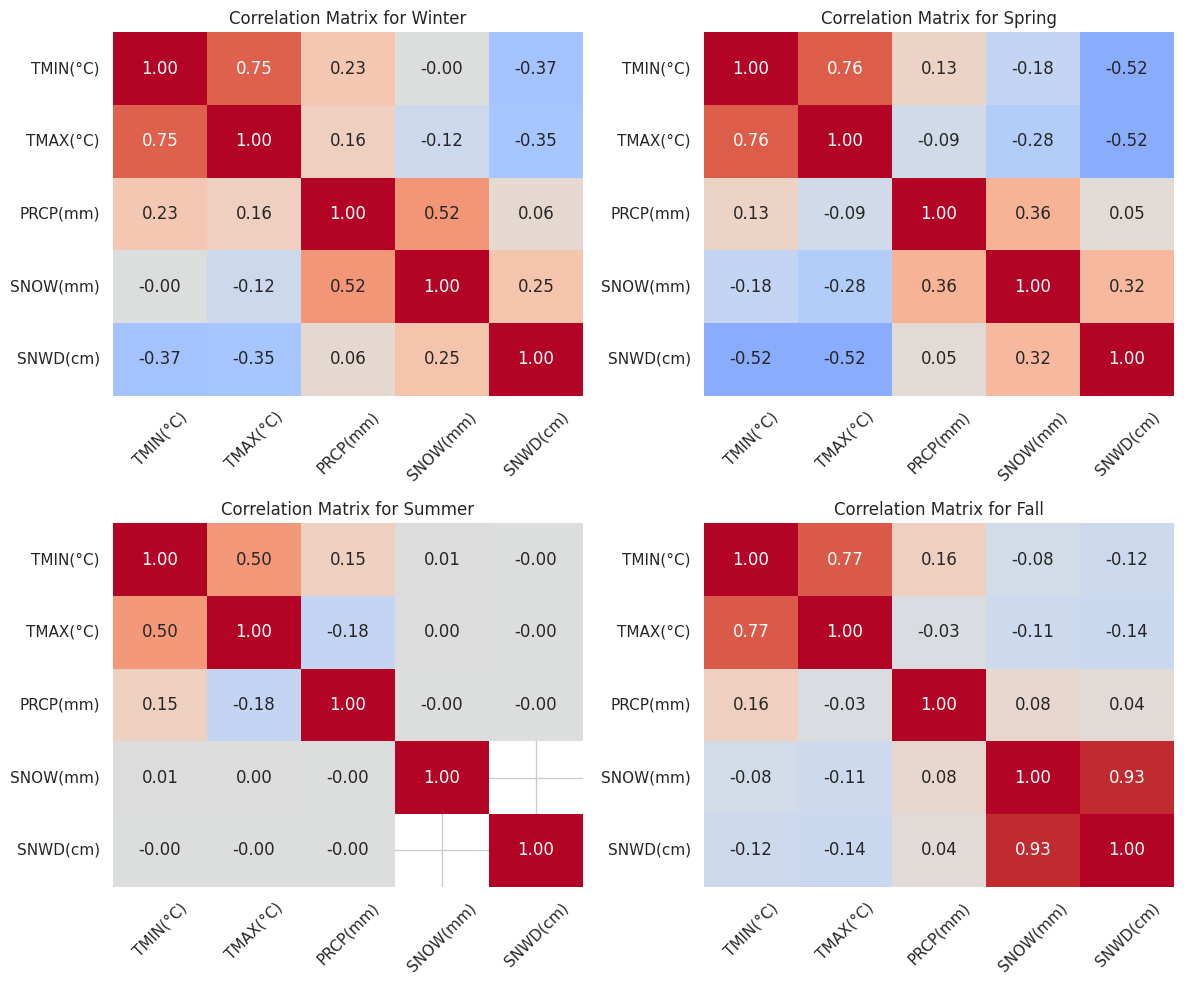

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlation for all seasons in a single figure with 4 quadrants
def plot_seasonal_correlations_in_quadrants(correlation_matrices):
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the size of the figure
    
    # Iterate over the seasons and their corresponding subplot axes
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, (season, corr_matrix) in enumerate(correlation_matrices.items()):
        row = i // 2  # Determine row (0 or 1)
        col = i % 2   # Determine column (0 or 1)
        
        # Plot the heatmap for each season in the corresponding subplot
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                    ax=axes[row, col], cbar=False, fmt='.2f')
        
        # Set the title and axis labels for each subplot
        axes[row, col].set_title(f'Correlation Matrix for {season}')
        axes[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
        axes[row, col].tick_params(axis='y', rotation=0)   # Keep y-axis labels upright
    
    # Adjust the layout to prevent overlap and show the figure
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'correlation_matrices' is a dictionary with the correlation matrices for each season
plot_seasonal_correlations_in_quadrants(correlation_matrices)


In [87]:
import pandas as pd

# Group by 'ID' (Station) and 'Season' and then apply describe
season_station_desc = df.groupby(['ID','Season']).describe().round(2)

# List of attributes (columns) you want to analyze
attributes = ['TMIN(°C)', 'TMAX(°C)', 'PRCP(mm)', 'SNOW(mm)', 'SNWD(cm)']

# Loop over each attribute and display its descriptive statistics
for attribute in attributes:
    print(f"Descriptive Statistics for {attribute}:")
    print(season_station_desc[attribute])
    print("\n" + "="*50 + "\n")  # Separator for better readability


Descriptive Statistics for TMIN(°C):
                      count   mean   std   min   25%   50%   75%    max
ID          Season                                                     
USC00272174 Fall    11680.0   3.79  6.74 -25.0  -1.1   3.3   8.9   23.9
            Spring  11722.0   0.78  6.47 -27.8  -3.3   0.6   5.0   30.0
            Summer  11801.0  12.98  4.31  -2.2  10.0  13.3  16.1   29.4
            Winter  11543.0  -9.07  6.74 -37.2 -13.3  -8.3  -3.9   15.0
USC00272999 Fall     9169.0   0.26  6.87 -25.0  -3.9   0.0   5.0   20.0
            Spring   9266.0  -4.62  8.96 -37.8  -9.4  -2.8   1.1   18.3
            Summer   9243.0   9.77  4.35  -3.9   6.7  10.0  12.8   22.2
            Winter   9140.0 -16.83  9.11 -71.1 -23.3 -16.7  -9.4    8.3
USC00273850 Fall    11889.0   3.39  6.86 -24.4  -1.7   3.3   8.3   22.2
            Spring  11941.0   0.11  7.30 -35.0  -3.9   0.0   5.0   24.4
            Summer  11991.0  13.01  4.19 -10.6  10.0  13.3  16.1   25.0
            Winter  11782.0

In [91]:
df.head()

ID  Season  TMIN(°C)  TMAX(°C)  PRCP(mm)  SNOW(mm)  \
DATE                                                                      
1893-01-01  USC00272174  Winter     -11.1       2.2      19.8       NaN   
1893-01-02  USC00272174  Winter      -5.6       9.4       0.0       NaN   
1893-01-03  USC00272174  Winter      -7.8       9.4       0.0       NaN   
1893-01-04  USC00272174  Winter     -17.2      -0.6       0.0       NaN   
1893-01-05  USC00272174  Winter     -12.8      -1.7       0.0       NaN   

            SNWD(cm)  
DATE                  
1893-01-01       NaN  
1893-01-02       NaN  
1893-01-03       NaN  
1893-01-04       NaN  
1893-01-05       NaN

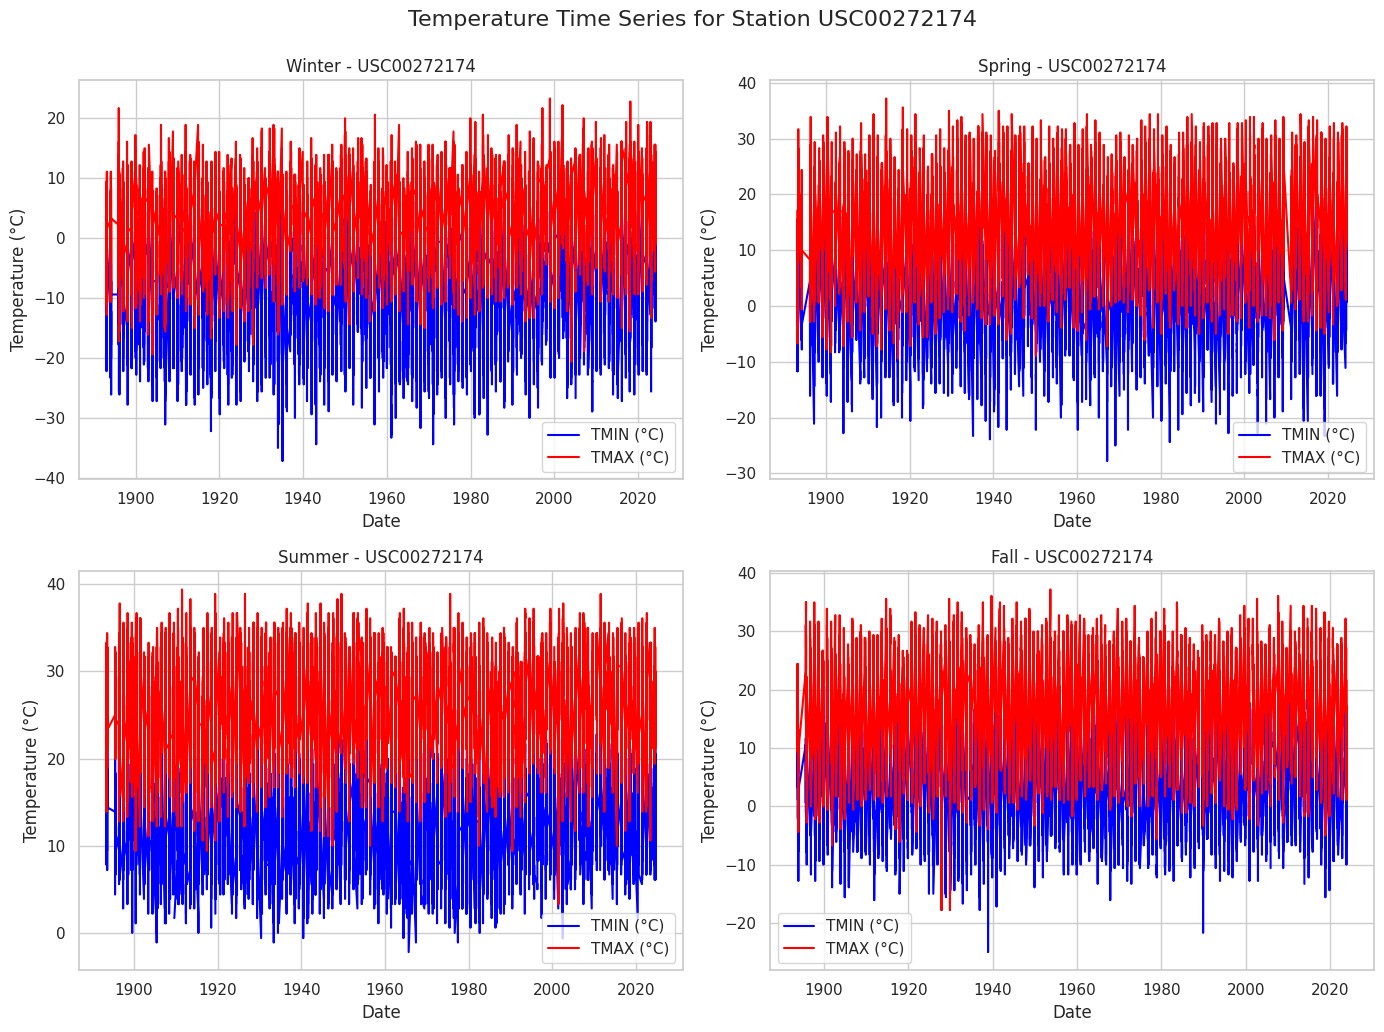

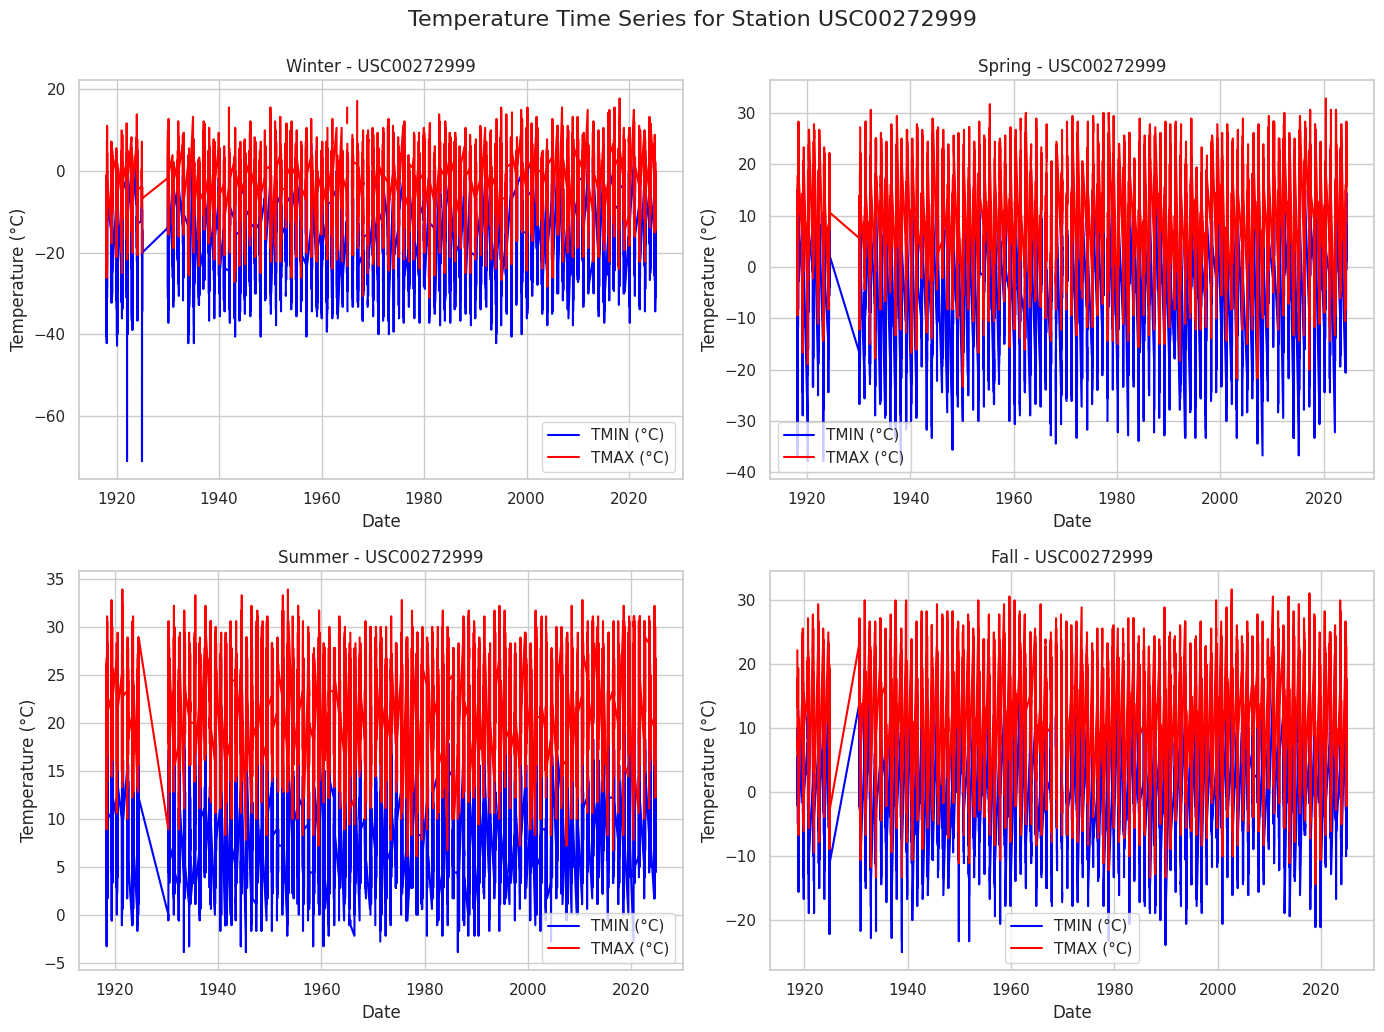

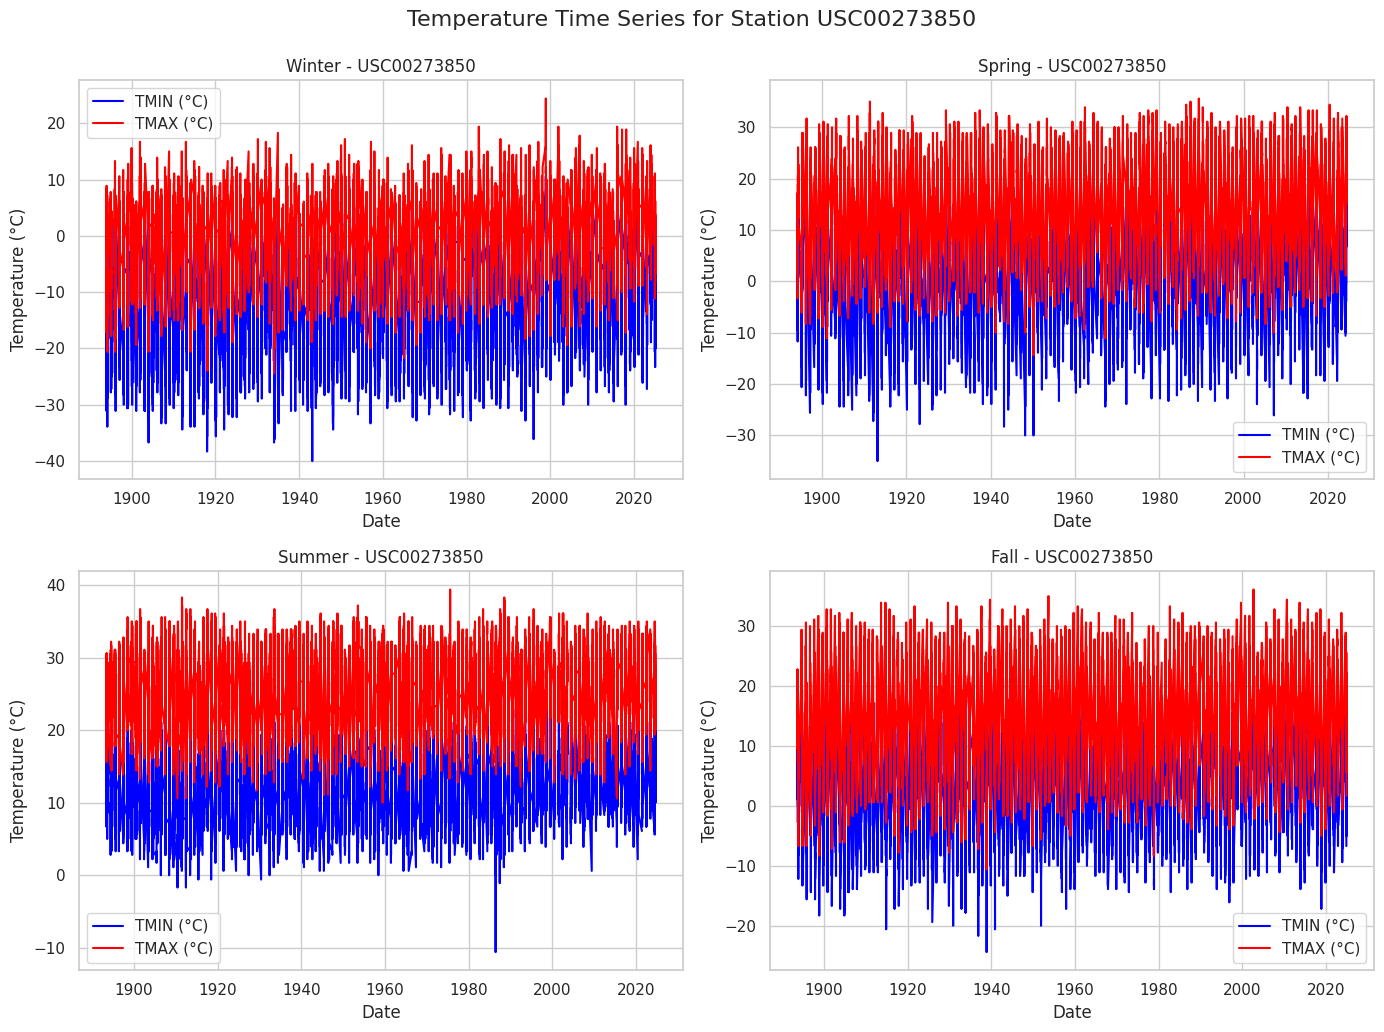

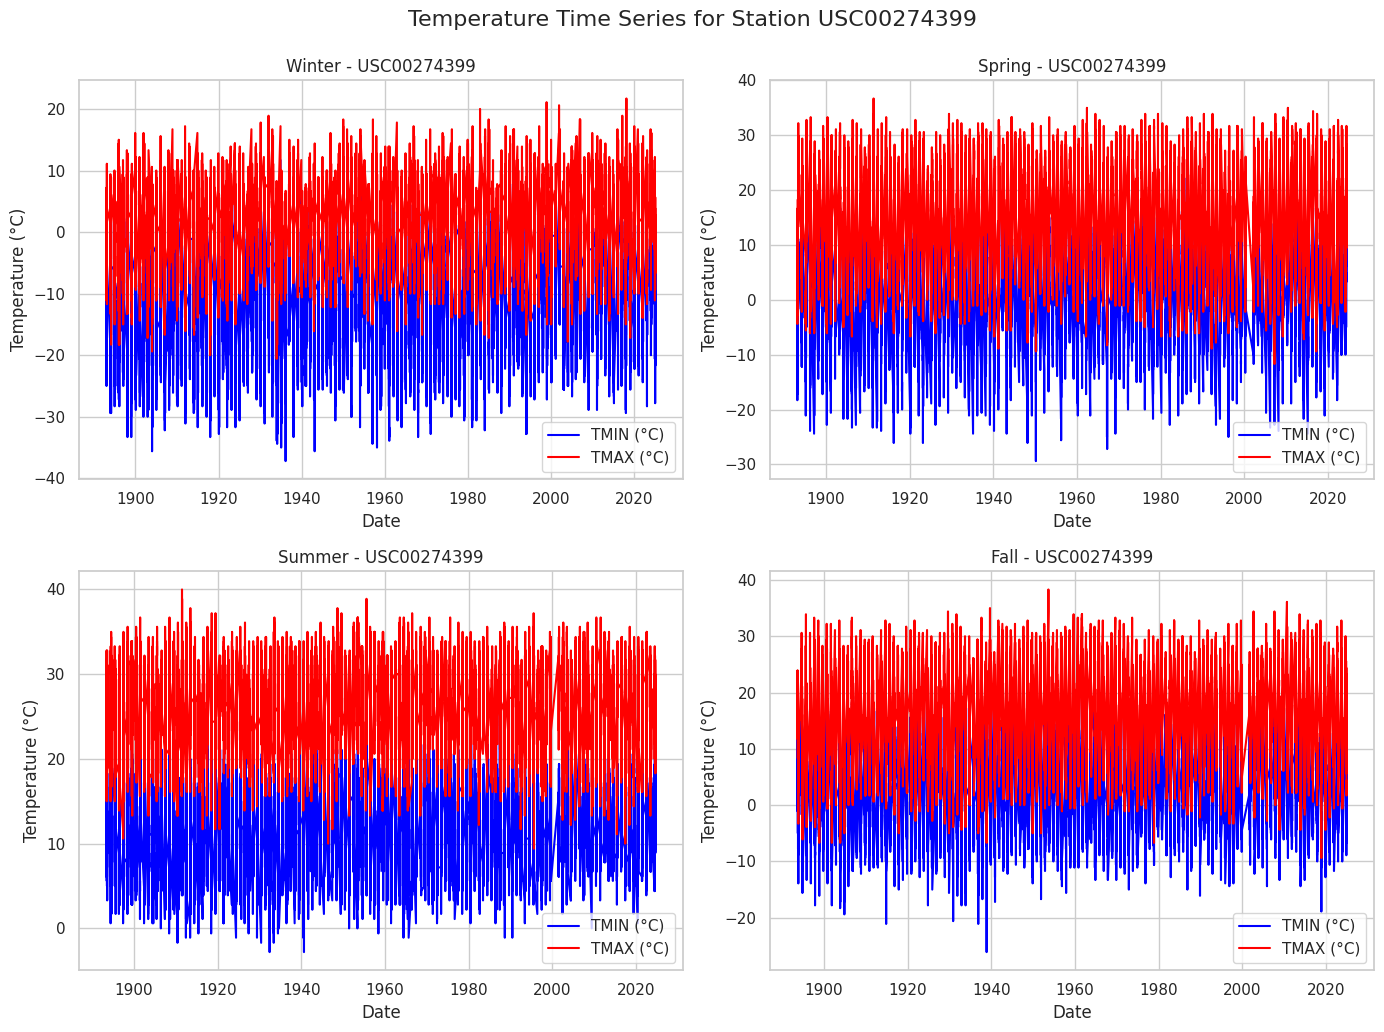

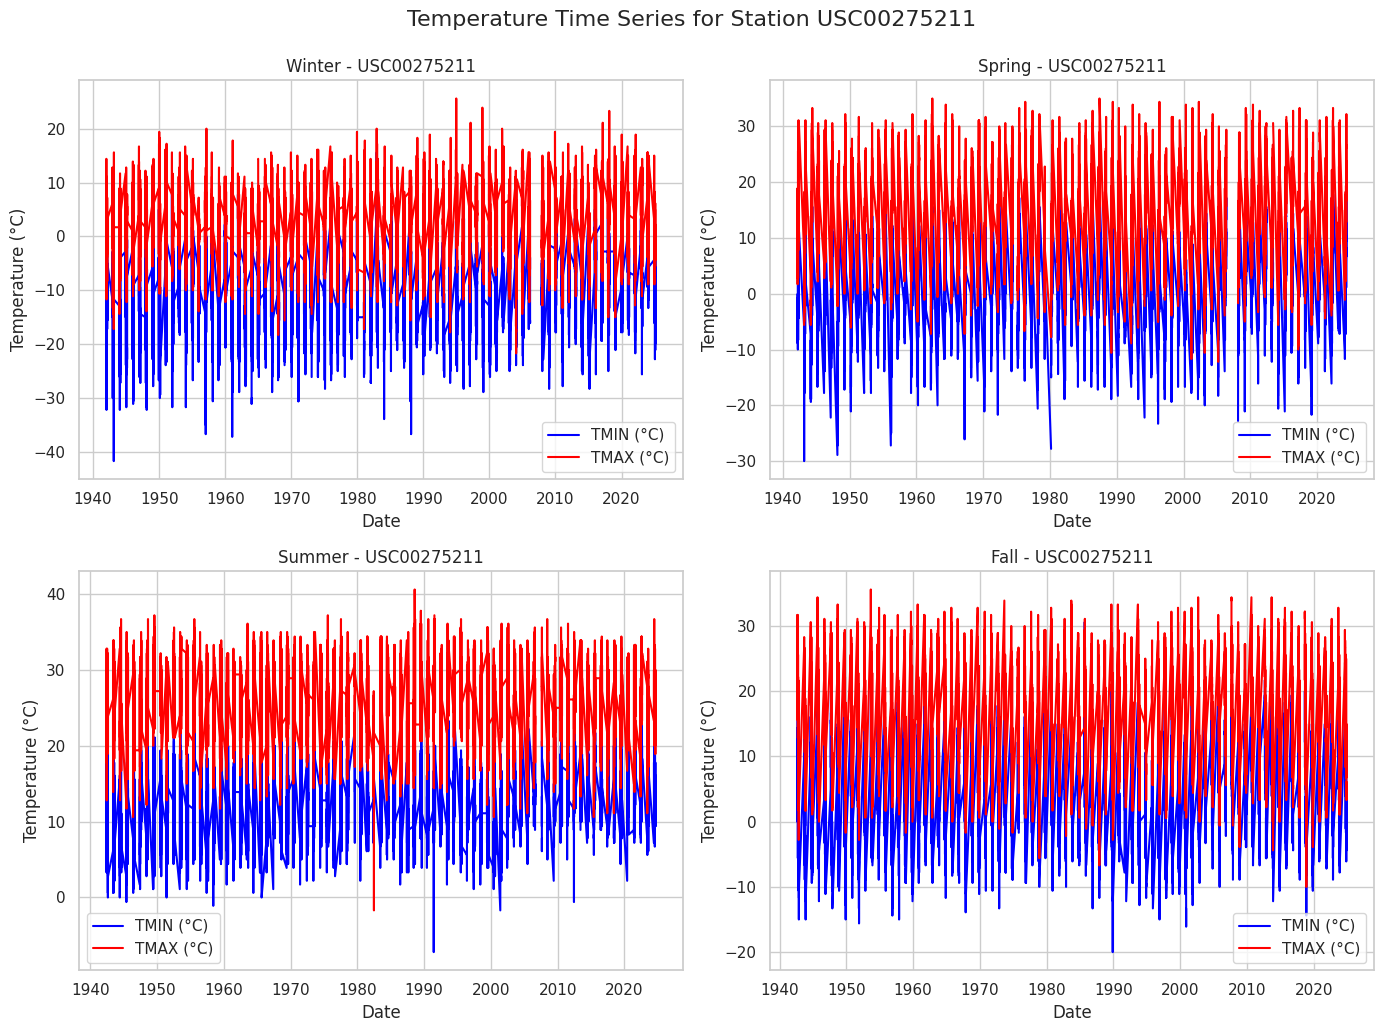

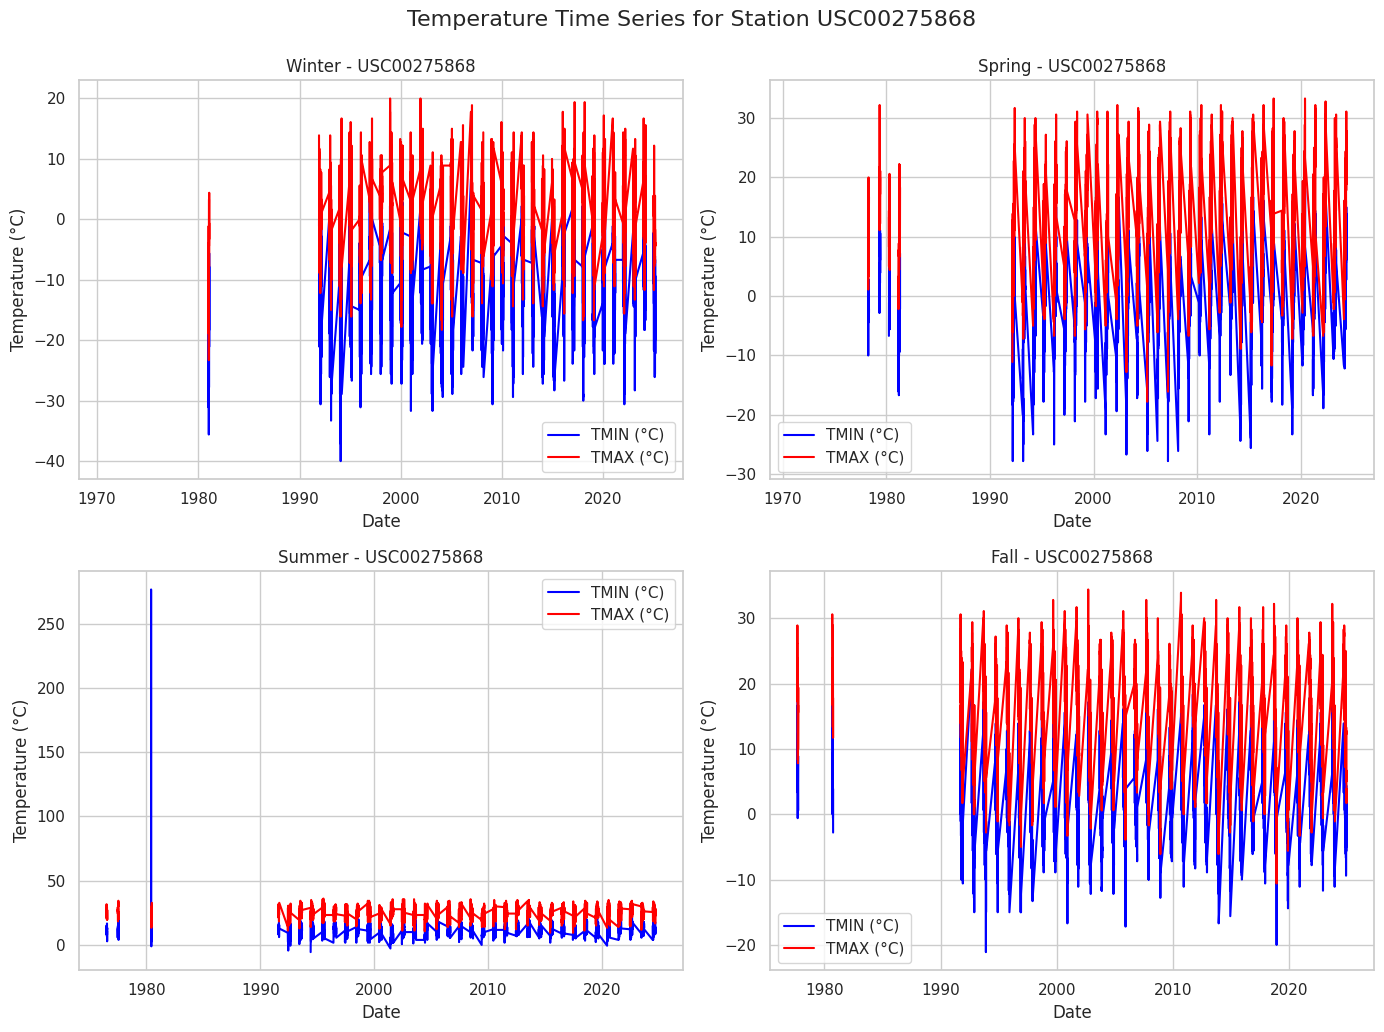

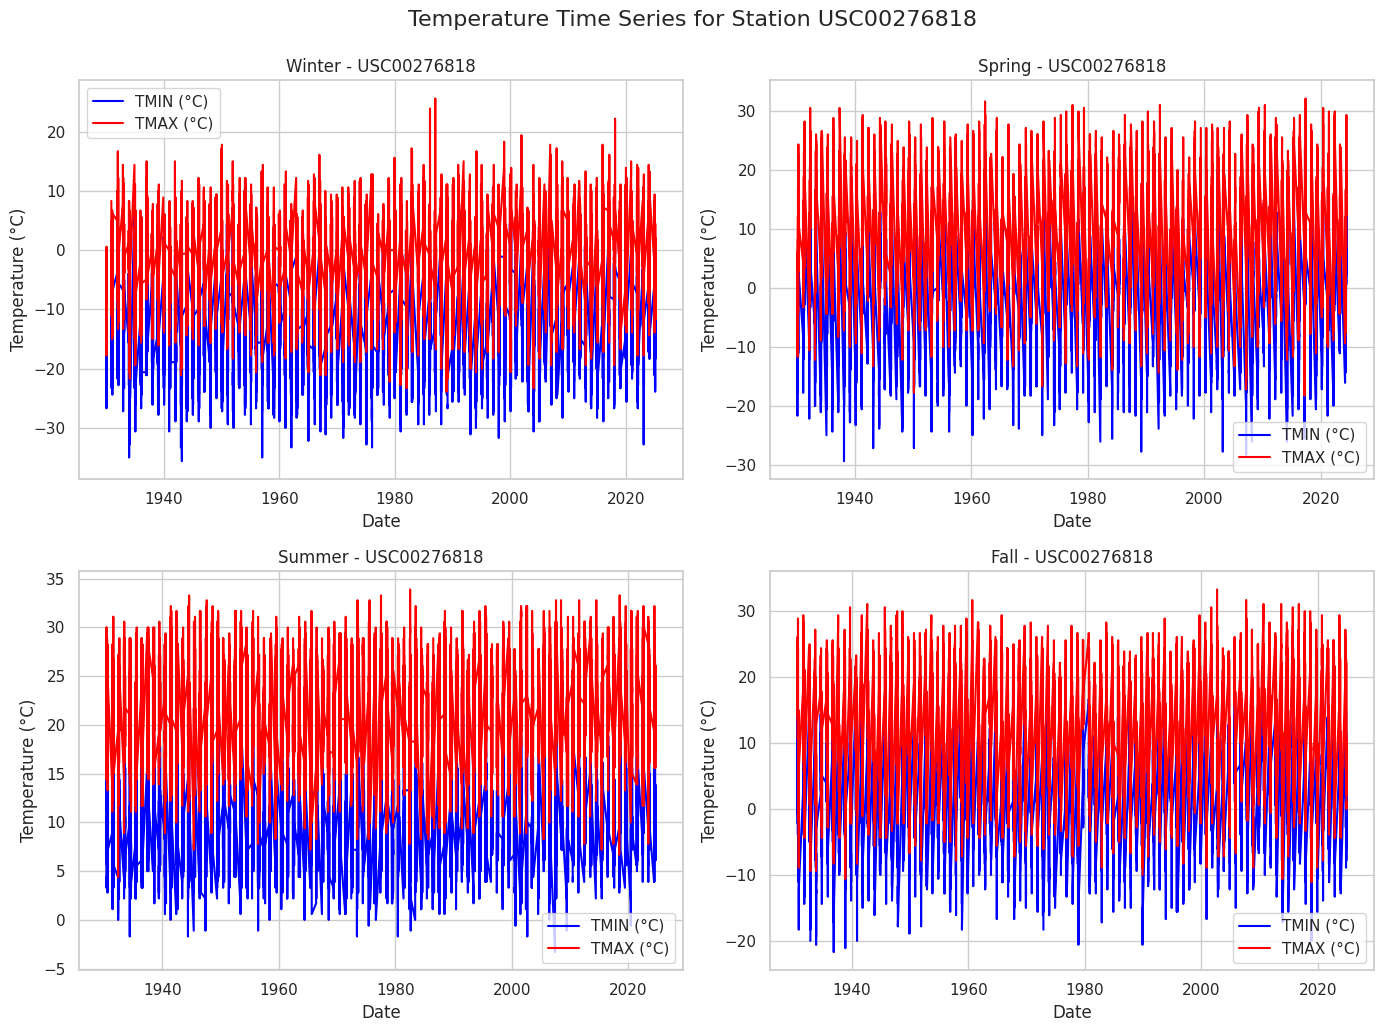

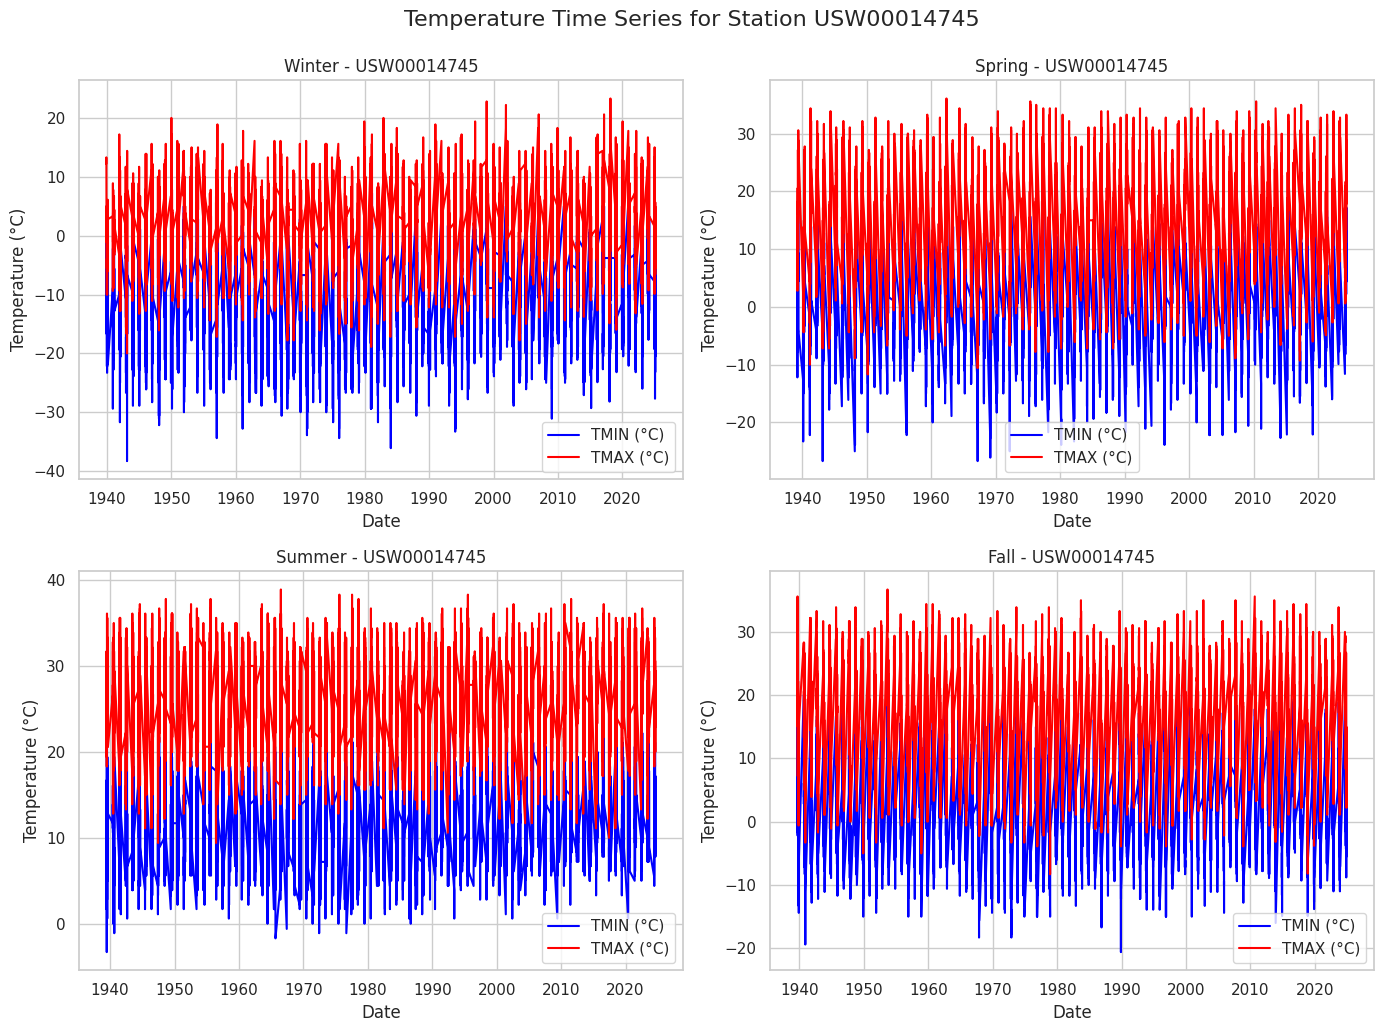

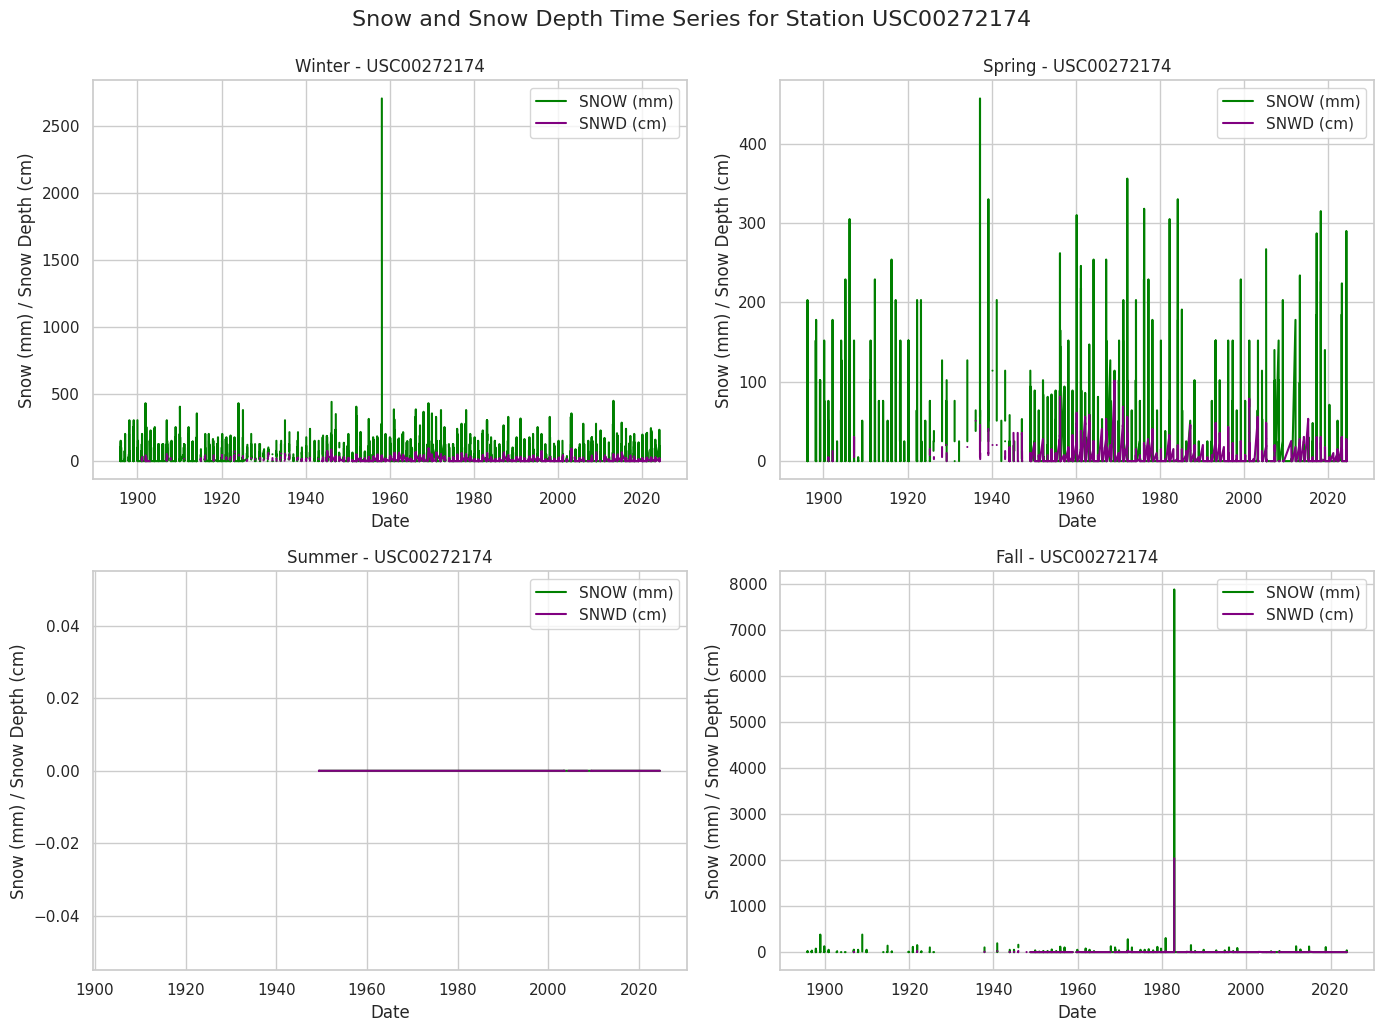

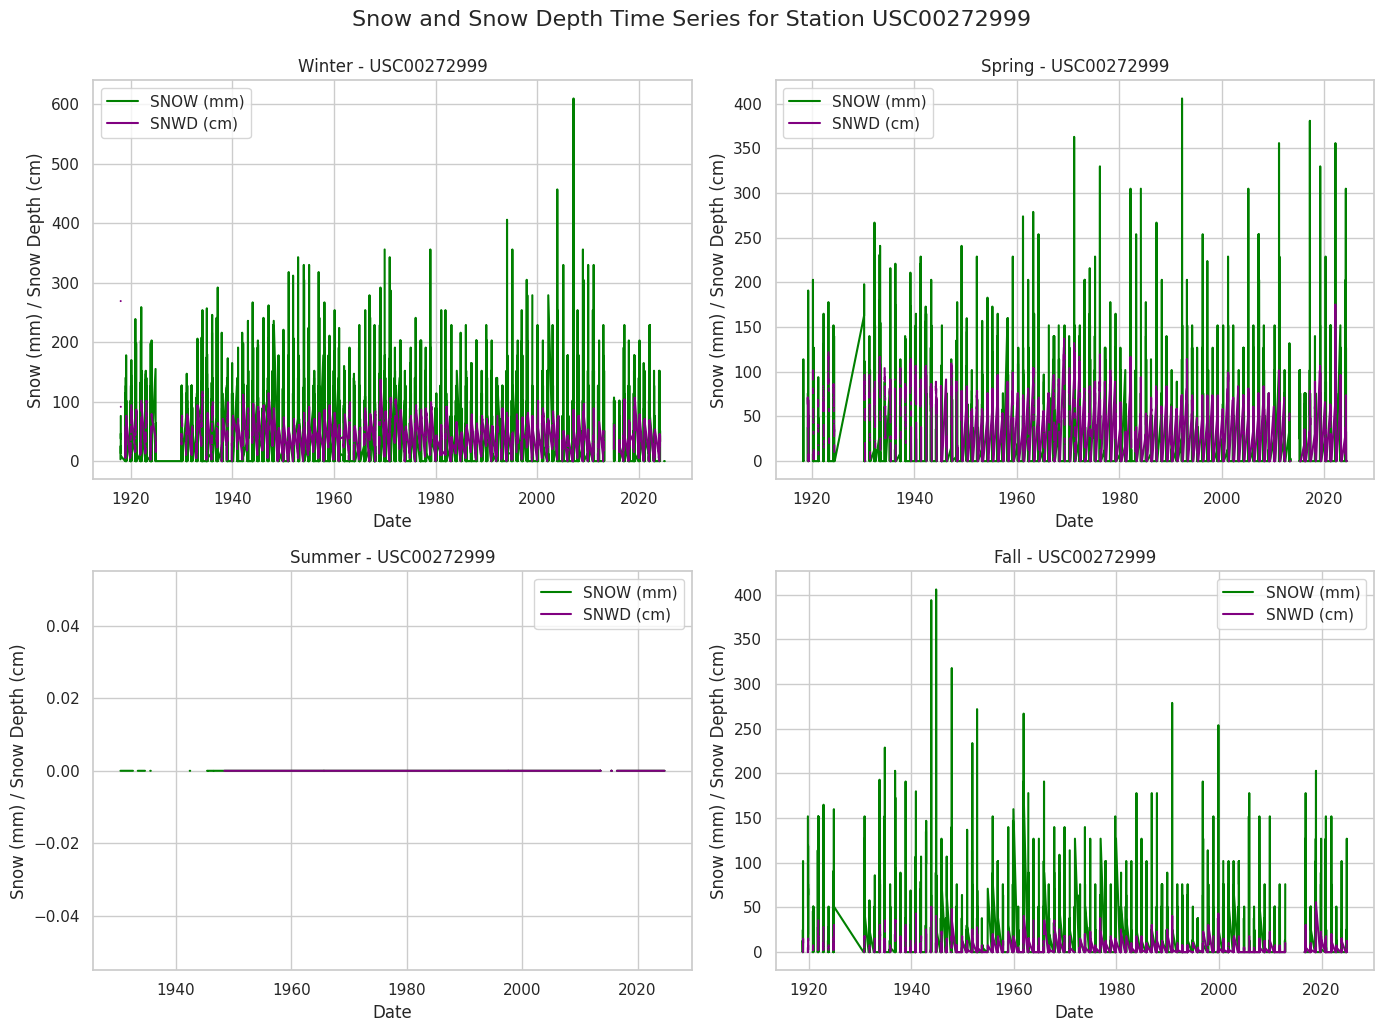

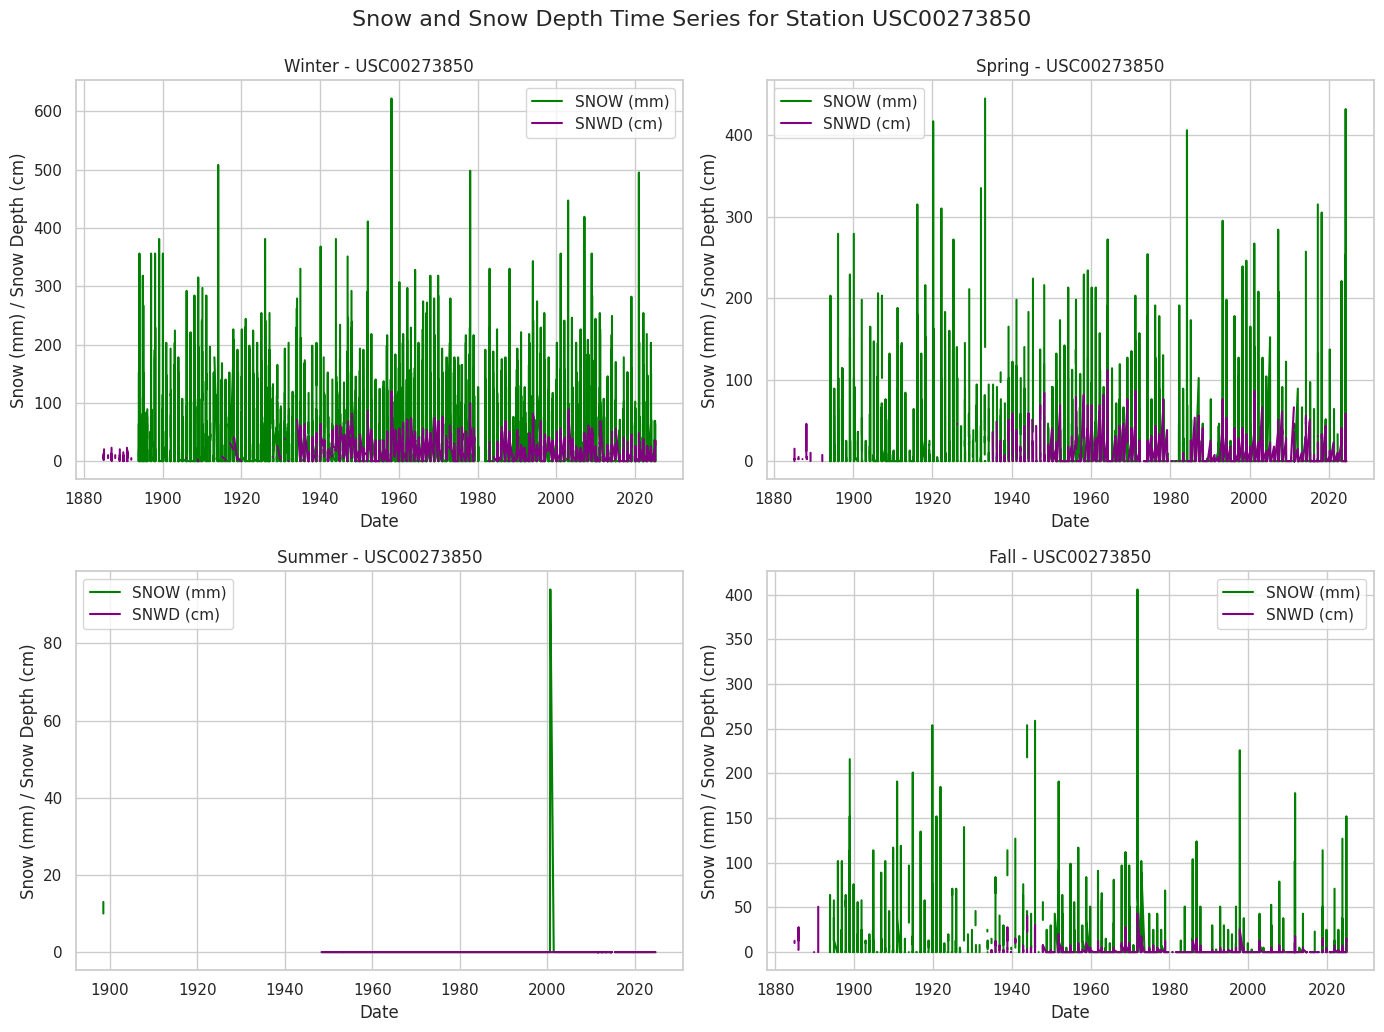

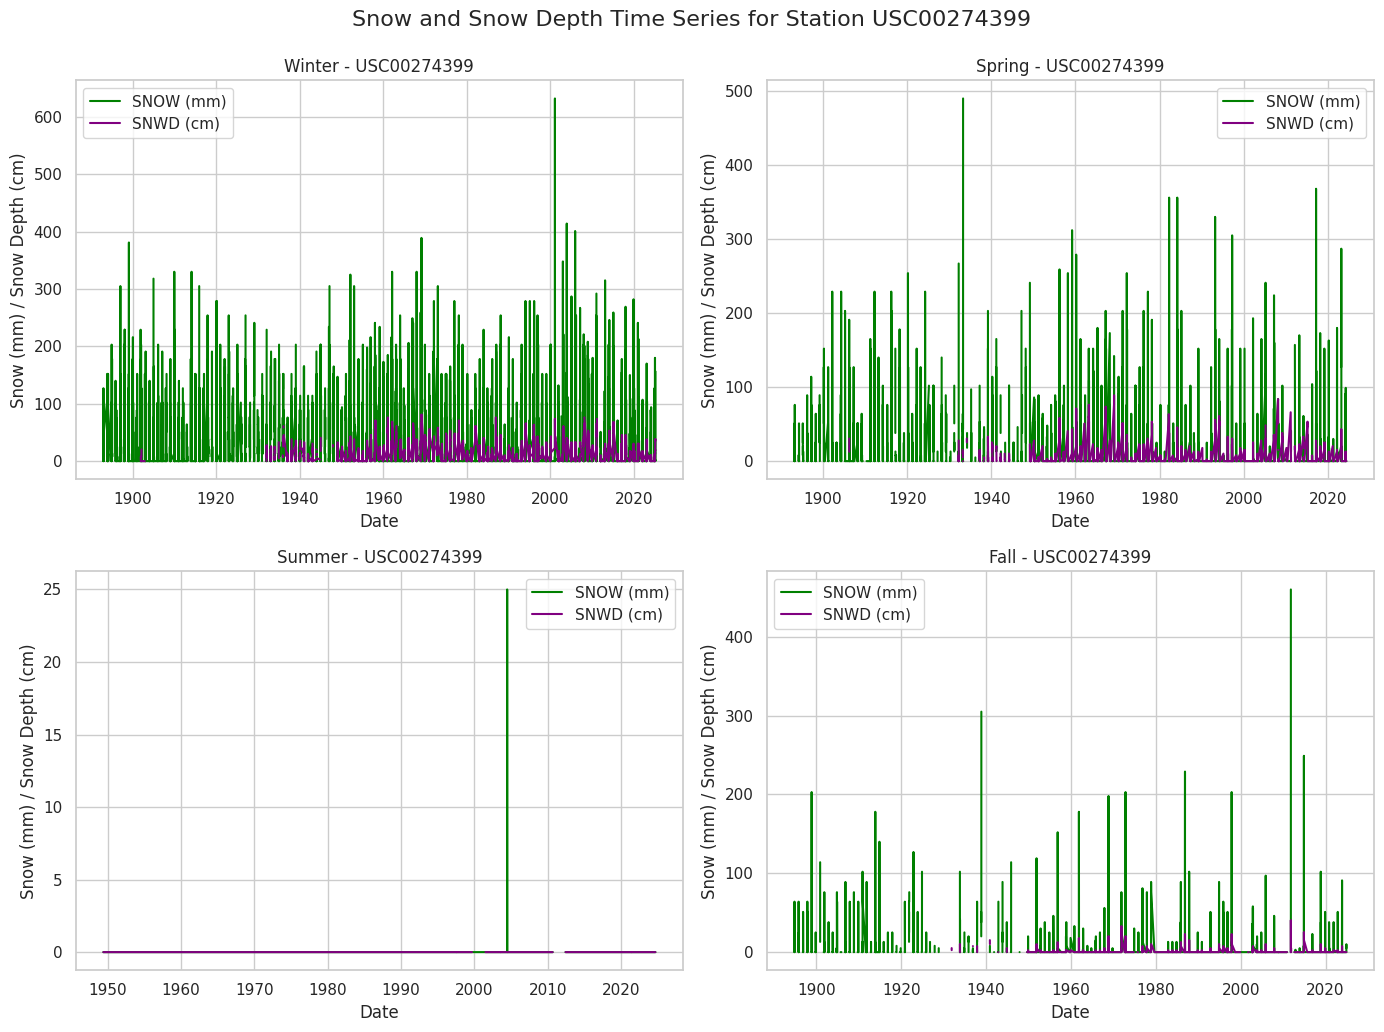

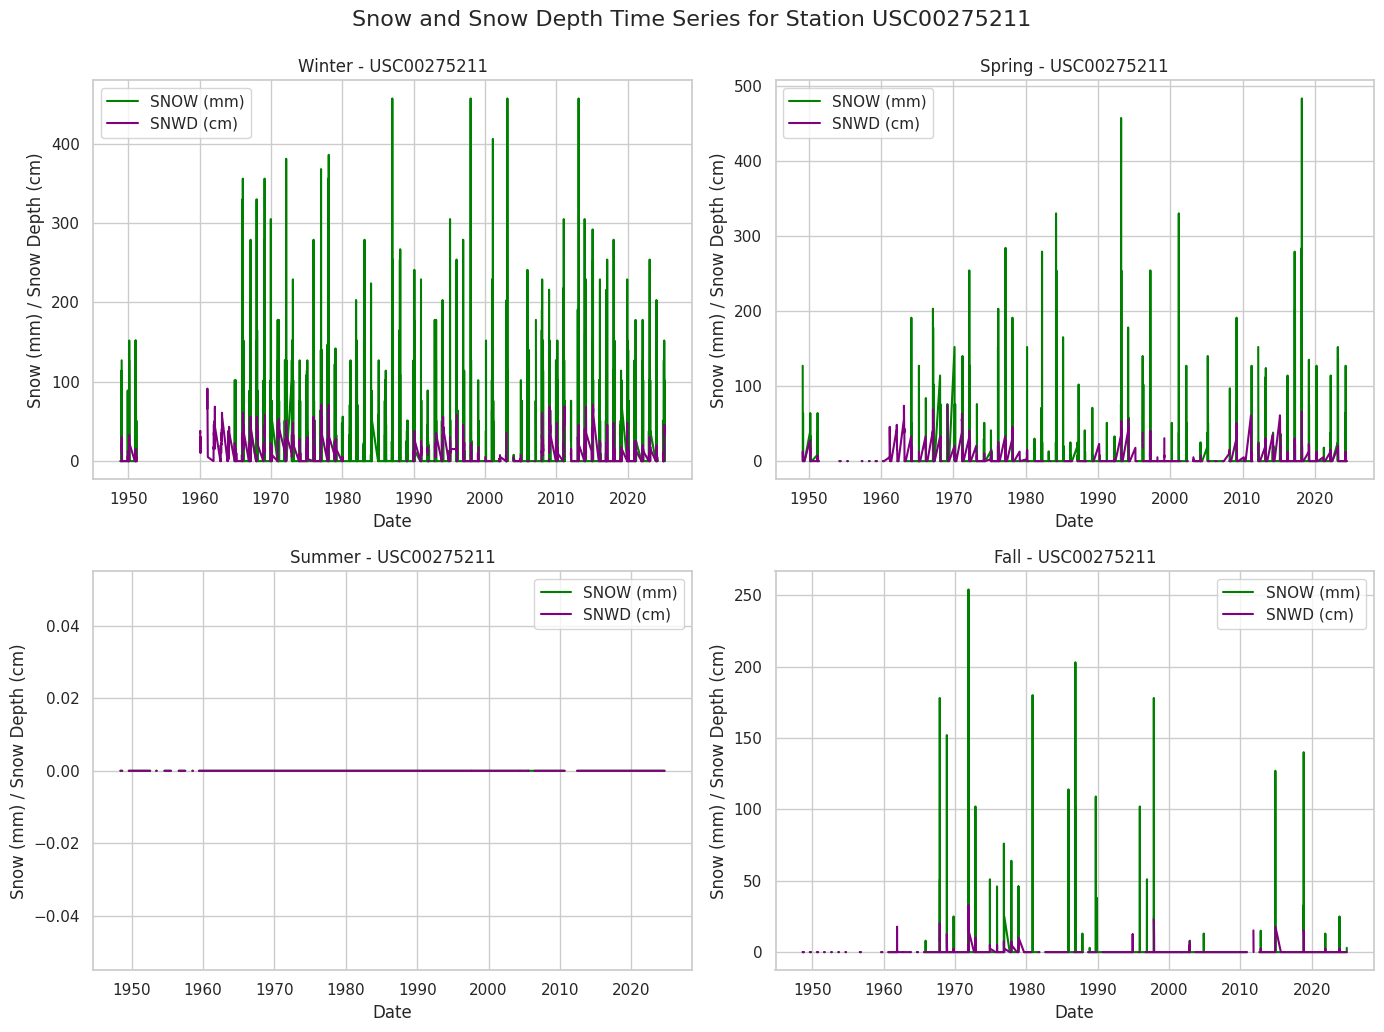

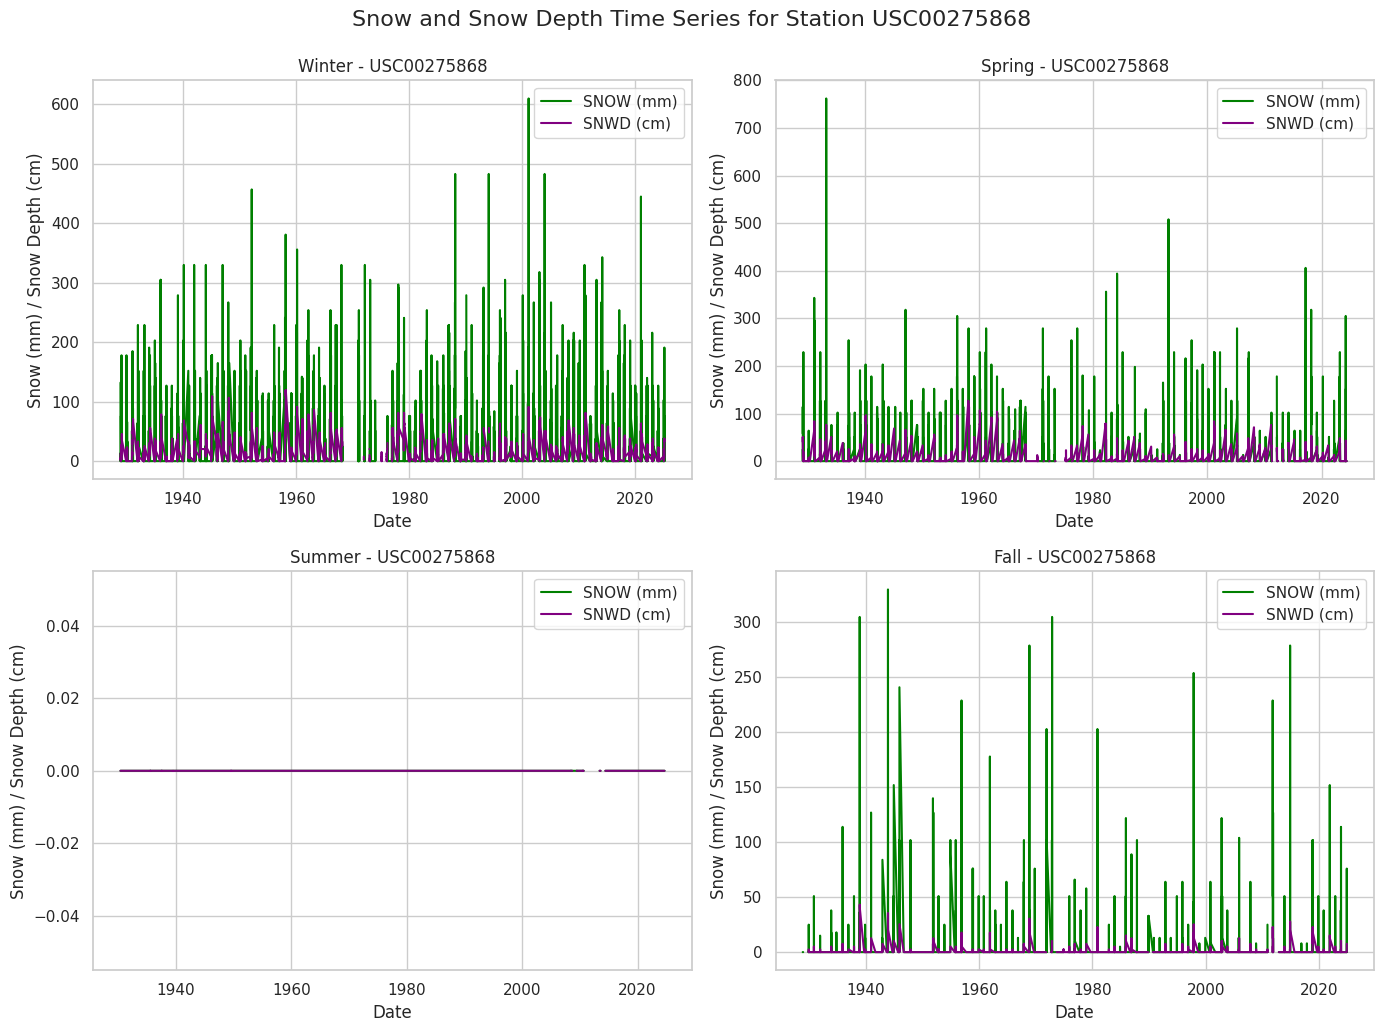

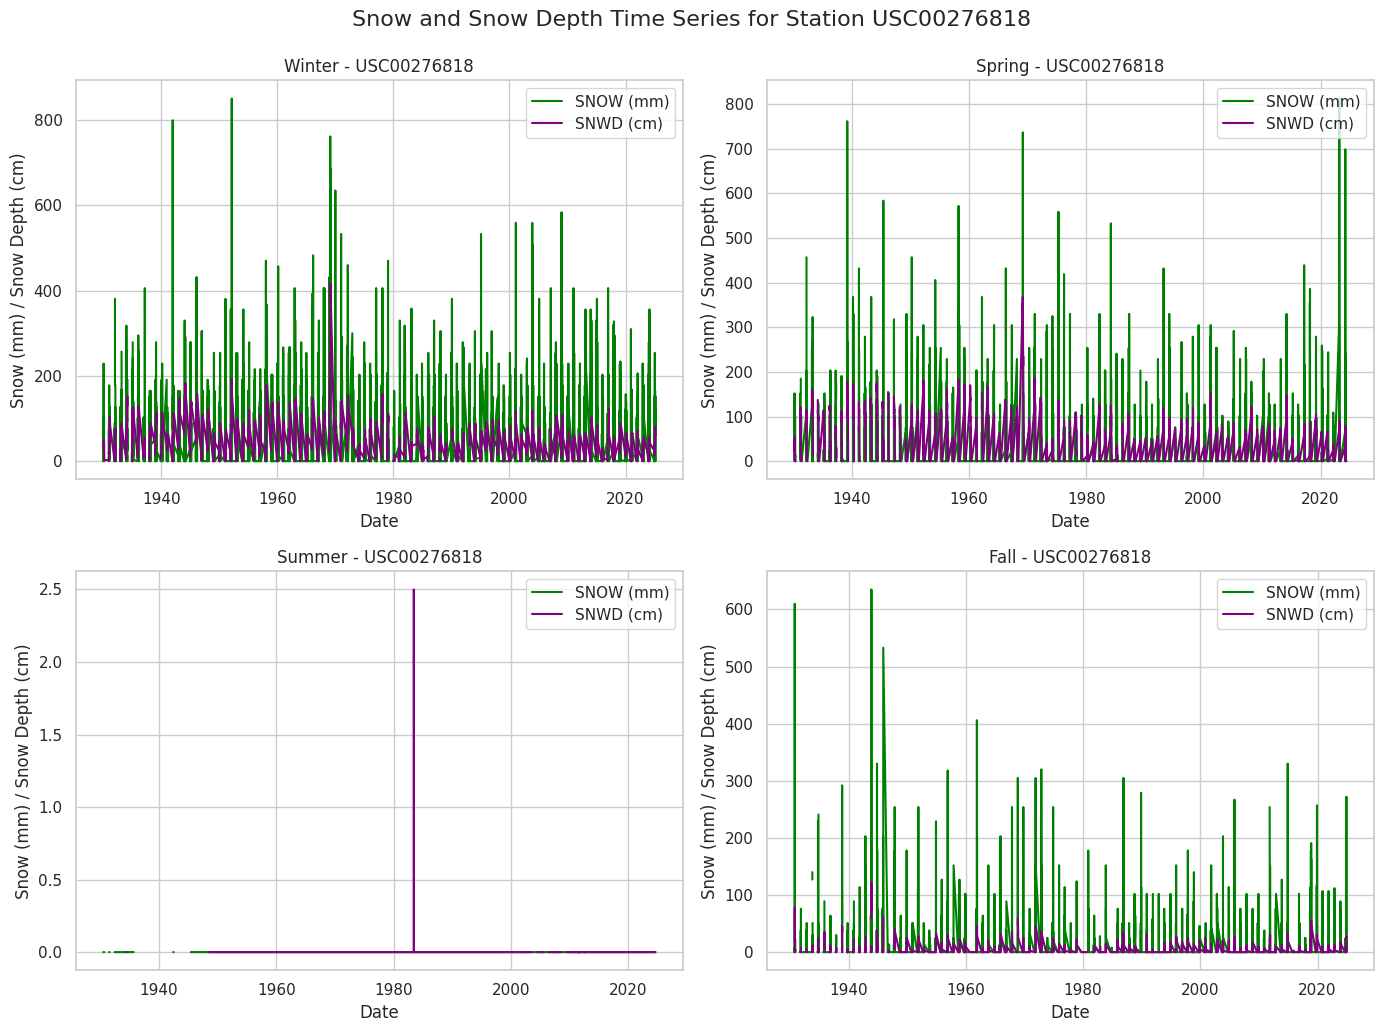

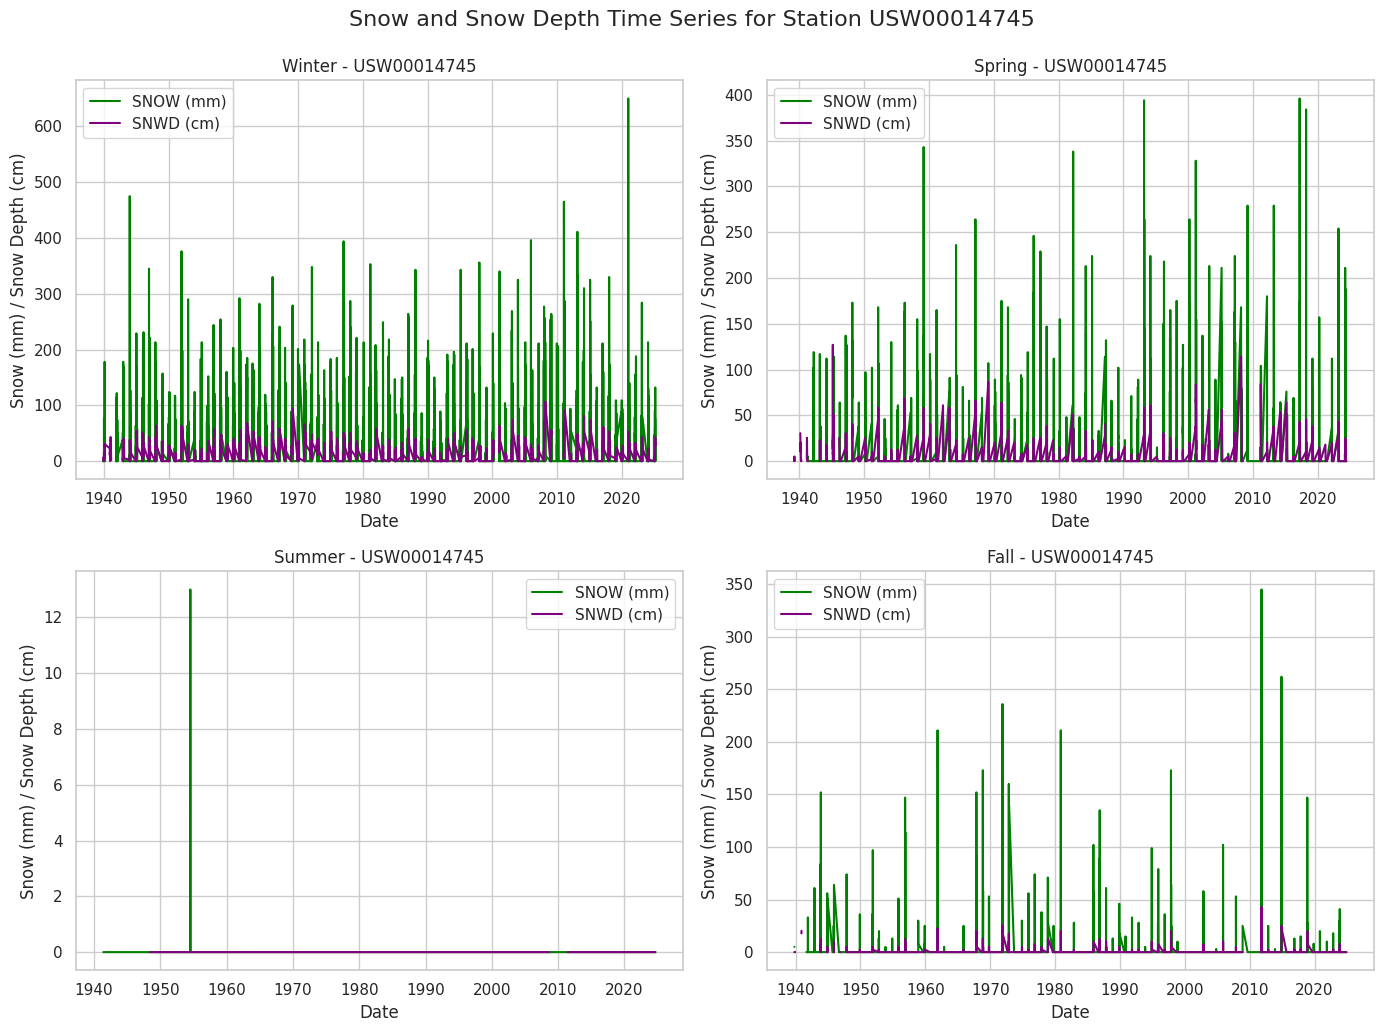

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has already been loaded
# Make sure that the 'DATE' column is a datetime object and set as the index

# Loop through each station (ID)
stations = df['ID'].unique()
for station in stations:
    station_data = df[df['ID'] == station]
    
    # Create a figure for each station
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid of subplots (4 seasons)
    axes = axes.flatten()  # Flatten to make it easier to access each subplot

    # Loop through each season and plot the data
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, season in enumerate(seasons):
        season_data = station_data[station_data['Season'] == season]
        
        # Plot the time series for TMIN and TMAX for the current season
        axes[i].plot(season_data.index, season_data['TMIN(°C)'], label='TMIN (°C)', color='blue')
        axes[i].plot(season_data.index, season_data['TMAX(°C)'], label='TMAX (°C)', color='red')
        
        # Set title and labels for each subplot
        axes[i].set_title(f"{season} - {station}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Temperature (°C)")
        axes[i].legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.suptitle(f"Temperature Time Series for Station {station}", fontsize=16, y=1.03)
    plt.show()

for station in stations:
    station_data = df[df['ID'] == station]
    
    # Create a figure for each station with 2x2 subplots (one for each season)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid for the four seasons
    axes = axes.flatten()  # Flatten to make it easier to access each subplot
    
    # Loop through each season and plot the data for SNOW and SNWD
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, season in enumerate(seasons):
        season_data = station_data[station_data['Season'] == season]
        
        # Plot the time series for SNOW and SNWD for the current season
        axes[i].plot(season_data.index, season_data['SNOW(mm)'], label='SNOW (mm)', color='green')
        axes[i].plot(season_data.index, season_data['SNWD(cm)'], label='SNWD (cm)', color='purple')
        
        # Set title and labels for each subplot
        axes[i].set_title(f"{season} - {station}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Snow (mm) / Snow Depth (cm)")
        axes[i].legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.suptitle(f"Snow and Snow Depth Time Series for Station {station}", fontsize=16, y=1.03)
    plt.show()
